<h1> Setting up HF and packages </h1>

In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
!huggingface-cli whoami

ShaanShah1


In [3]:
from llama_cpp import Llama
import time
import torch
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download
import psutil
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm
import ast
import re

<h1> List of Models to Analyze </h1>

In [20]:
list_of_model_outputs = os.listdir("model_outputs")
file_name_to_model_name = {
    'DeepSeek-R1-Distill-Llama-8B-Q4_K_M_gguf.txt': 'R1-Distill-Llama 8B',
    'DeepSeek-R1-Distill-Qwen-1_5B-Q4_K_M_gguf.txt': 'R1-Distill-Qwen 1.5B',
    'DeepSeek-R1-Distill-Qwen-7B-Q6_K_gguf.txt': 'R1-Distill-Qwen 7B',
    'Llama-3_2-1B-Instruct_Q4_K_M_gguf.txt': 'Llama 3.2 1B',
    'Llama-3_2-3B-Instruct-Q4_K_M_gguf.txt': 'Llama 3.2 3B',
    'Meta-Llama-3_1-8B-Instruct-Q4_K_M_gguf.txt': 'Llama 3.1 8B',
    'qwen2-0_5b-instruct-q4_k_m_gguf.txt': 'Qwen2 0.5B',
    'qwen2-1_5b-instruct-q4_k_m_gguf.txt': 'Qwen2 1.5B',
    'qwen2-7b-instruct-q4_k_m_gguf.txt': 'Qwen2 7B'
}
list_of_model_outputs

['DeepSeek-R1-Distill-Llama-8B-Q4_K_M_gguf.txt',
 'DeepSeek-R1-Distill-Qwen-1_5B-Q4_K_M_gguf.txt',
 'DeepSeek-R1-Distill-Qwen-7B-Q6_K_gguf.txt',
 'Llama-3_2-1B-Instruct_Q4_K_M_gguf.txt',
 'Llama-3_2-3B-Instruct-Q4_K_M_gguf.txt',
 'Meta-Llama-3_1-8B-Instruct-Q4_K_M_gguf.txt',
 'qwen2-0_5b-instruct-q4_k_m_gguf.txt',
 'qwen2-1_5b-instruct-q4_k_m_gguf.txt',
 'qwen2-7b-instruct-q4_k_m_gguf.txt']

<h1> Reading in the model data </h1>

In [21]:
def read_model_outputs(model_name):
    """
    Reads the output file for the given model and returns a list of dictionaries,
    each representing the results for one prompt.

    Args:
        model_name (str): The original model name (e.g., "some/model").

    Returns:
        list: A list of dictionaries read from the file.
    """
    # Sanitize the model name (replace "/" with "_") to match the file naming
    model_name_sanitized = model_name.replace("/", "_")
    file_path = f"model_outputs/{model_name_sanitized}"
    
    results = []
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"No output file found for model '{model_name_sanitized}'.")
        print(f"No output file found for model '{model_name}'.")
        return results
    
    # Open and read the file line by line
    with open(file_path, "r", encoding="utf-8") as infile:
        for line in infile:
            line = line.strip()
            if line:
                try:
                    # Convert the string representation of the dictionary into a dict
                    result_dict = ast.literal_eval(line)
                    results.append(result_dict)
                except Exception as e:
                    print(f"Error parsing line: {line}\nError: {e}")
                    
    return results

<h1> Eval Code </h1>

In [22]:
def eval_answer(model_output, answer_key):
    """
    Evaluates the model output by scanning the entire string for the answer_key.
    
    For numeric answer_keys, it searches for any number (allowing an optional '$' and commas)
    that, when converted to a float, equals answer_key. For non-numeric answer_keys, it checks
    whether the answer_key appears anywhere in the string.
    
    Returns:
        1 if a matching answer is found, 0 otherwise.
    """
    # Determine whether answer_key is numeric.
    try:
        answer_key_numeric = float(answer_key)
        answer_key_is_numeric = True
    except (ValueError, TypeError):
        answer_key_is_numeric = False

    if answer_key_is_numeric:
        # Find all numeric tokens in the model output. The regex allows an optional '$' and commas.
        numbers = re.findall(r"\$?([-+]?\d[\d,]*\.?\d*)", model_output)
        for num in numbers:
            # Remove commas from the extracted number.
            num_clean = num.replace(',', '')
            try:
                extracted_num = float(num_clean)
            except ValueError:
                continue  # Skip if conversion fails.
            # Compare the extracted number with the answer_key.
            if extracted_num == answer_key_numeric:
                print(f"Found matching numeric answer: {extracted_num} equals answer key: {answer_key_numeric}")
                return 1
        print("No matching numeric answer found in model output.")
        return 0
    else:
        # For non-numeric answer keys, check if the answer_key appears anywhere in the output.
        # Using re.search to allow for case-sensitive matching.
        if re.search(re.escape(str(answer_key)), model_output):
            print(f"Found matching string answer: '{answer_key}' in model output.")
            return 1
        else:
            print("No matching string answer found in model output.")
            return 0

# Example usage:
example1_model = ("Janet has 16 eggs per day, so 16 - 3 = 13 eggs left. "
                  "13 eggs * 4 eggs per muffin = 52 muffins per day. 52 muffins * $2 per muffin = 104 dollars per day.")
example1_key = 104.0  # Expected to return 1 since 104 appears in the string.

example2_model = "2 bolts of blue fiber, and 2.5 bolts of white fiber. 2 + 2.5 = 4.5."
example2_key = 4.5   # Expected to return 1 since 4.5 appears in the string.

example3_model = "The result computed is twenty."
example3_key = "twenty"   # Expected to return 1 since 'twenty' appears in the string.

print("Result for example 1:", eval_answer(example1_model, example1_key))
print("Result for example 2:", eval_answer(example2_model, example2_key))
print("Result for example 3:", eval_answer(example3_model, example3_key))


Found matching numeric answer: 104.0 equals answer key: 104.0
Result for example 1: 1
Found matching numeric answer: 4.5 equals answer key: 4.5
Result for example 2: 1
Found matching string answer: 'twenty' in model output.
Result for example 3: 1


In [23]:
final_model_results = {}
for model_index in range(len(list_of_model_outputs)):
    data_out = read_model_outputs(list_of_model_outputs[model_index])
    eval_result = 0
    count = 0
    latency = 0 
    throughput = 0
    max_ram = 0 
    tokens_generated = 0
    for i in range(len(data_out)):
        count += 1
    print(f"Model: {file_name_to_model_name[list_of_model_outputs[model_index]]}", count)

Model: R1-Distill-Llama 8B 120
Model: R1-Distill-Qwen 1.5B 120
Model: R1-Distill-Qwen 7B 120
Model: Llama 3.2 1B 351
Model: Llama 3.2 3B 120
Model: Llama 3.1 8B 120
Model: Qwen2 0.5B 160
Model: Qwen2 1.5B 120
Model: Qwen2 7B 120


In [24]:
final_model_results = {}
for model_index in range(len(list_of_model_outputs)):
    data_out = read_model_outputs(list_of_model_outputs[model_index])
    print(f"Model: {file_name_to_model_name[list_of_model_outputs[model_index]]}")
    eval_result = 0
    count = 0
    latency = 0 
    throughput = 0
    max_ram = 0 
    tokens_generated = 0
    for i in range(len(data_out)):
        eval_result += eval_answer(data_out[i]['model_output'], data_out[i]['answer'])
        latency += data_out[i]['latency']
        throughput += data_out[i]['throughput'] 
        max_ram += data_out[i]['max_ram']
        tokens_generated += data_out[i]['tokens_generated']
        count += 1
    print(f"Accuracy: {eval_result/count}")
    dict_to_save = {
        "Accuracy": eval_result/count, 
        "Latency": latency/count,
        "Throughput": throughput/count,
        "Max RAM": max_ram/count,
        "Tokens Generated": tokens_generated/count
    }
    final_model_results[file_name_to_model_name[list_of_model_outputs[model_index]]] = dict_to_save

Model: R1-Distill-Llama 8B
Found matching numeric answer: 366.0 equals answer key: 366.0
Found matching numeric answer: 694.0 equals answer key: 694.0
No matching numeric answer found in model output.
No matching numeric answer found in model output.
Found matching numeric answer: 60.0 equals answer key: 60.0
No matching numeric answer found in model output.
Found matching numeric answer: 230.0 equals answer key: 230.0
Found matching numeric answer: 57500.0 equals answer key: 57500.0
Found matching numeric answer: 7.0 equals answer key: 7.0
Found matching numeric answer: 6.0 equals answer key: 6.0
Found matching numeric answer: 15.0 equals answer key: 15.0
No matching numeric answer found in model output.
Found matching numeric answer: 7.0 equals answer key: 7.0
Found matching numeric answer: 8.0 equals answer key: 8.0
No matching numeric answer found in model output.
No matching numeric answer found in model output.
Found matching numeric answer: 243.0 equals answer key: 243.0
Found m

In [25]:
final_model_results

{'R1-Distill-Llama 8B': {'Accuracy': 0.6666666666666666,
  'Latency': 10.459565216302872,
  'Throughput': 17.097379264569803,
  'Max RAM': 5.148382949829101,
  'Tokens Generated': 178.64166666666668},
 'R1-Distill-Qwen 1.5B': {'Accuracy': 0.05,
  'Latency': 2.190526912609736,
  'Throughput': 57.49948615899042,
  'Max RAM': 1.5082692464192708,
  'Tokens Generated': 132.49166666666667},
 'R1-Distill-Qwen 7B': {'Accuracy': 0.675,
  'Latency': 11.824233170350393,
  'Throughput': 13.847759695161189,
  'Max RAM': 6.078561274210612,
  'Tokens Generated': 163.83333333333334},
 'Llama 3.2 1B': {'Accuracy': 0.2706552706552707,
  'Latency': 2.6769594181636798,
  'Throughput': 57.1560541319685,
  'Max RAM': 1.3456260050803508,
  'Tokens Generated': 90.3048433048433},
 'Llama 3.2 3B': {'Accuracy': 0.5416666666666666,
  'Latency': 2.6638007680575053,
  'Throughput': 26.32129569727709,
  'Max RAM': 2.589385986328125,
  'Tokens Generated': 75.8},
 'Llama 3.1 8B': {'Accuracy': 0.6916666666666667,
  'La

<h1> Plotting Data </h1>

In [30]:
def plot_model_metrics(model_names, metrics, units, model_data):
    """
    Plots bar graphs for each metric across the provided model names.

    Parameters:
    - model_names: list of str, the names of the models to include.
    - metrics: list of str, the metrics to plot (e.g., 'Latency', 'Throughput').
    - units: list of str, the corresponding units for each metric.
    - model_data: dict, where keys are model names and values are dictionaries 
                  containing the metric values.
    """
    
    for metric, unit in zip(metrics, units):
        # Extract metric values for the models (ignore models missing the metric)
        unit_str = f" ({unit})" if unit else ""
        values = []
        selected_models = []
        for model in model_names:
            if model in model_data and metric in model_data[model]:
                values.append(model_data[model][metric])
                selected_models.append(model)

        # Create a new figure for each metric with 350 dpi for publication quality
        plt.figure(figsize=(8, 5), dpi=350)

        # Plot bars with a custom color, bar width, and edge color
        bars = plt.bar(
            selected_models, 
            values, 
            color='#66b3ff',   # Light blue
            width=0.6         # Adjust as needed for thickness
        )
        
        # Add a title and axis labels with increased font sizes
        plt.title(f"{metric}{unit_str}", fontsize=16, pad=10)
        # plt.xlabel("Models", fontsize=14)
        plt.ylabel(f"{metric}{unit_str}", fontsize=14)

        # Rotate x-axis labels for clarity
        plt.xticks(rotation=0, ha='center', fontsize=12)
        plt.yticks(fontsize=12)

        # Add numeric labels on top of each bar with increased font size
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # X position in center of bar
                height,                            # Y position just above the bar
                f"{height:.2f}",                   # Format to 2 decimal places
                ha='center', va='bottom', 
                fontsize=12
            )
        
        # Make layout fit nicely
        plt.tight_layout()
        plt.show()


In [31]:
ordered_model_names = [
    'Qwen2 0.5B',
    'Llama 3.2 1B',
    'R1-Distill-Qwen 1.5B',
    'Qwen2 1.5B',
    'Llama 3.2 3B',
    'R1-Distill-Qwen 7B',
    'Qwen2 7B',
    'Llama 3.1 8B',
    'R1-Distill-Llama 8B'
]

metrics = ['Accuracy', 'Latency', 'Throughput', 'Max RAM', 'Tokens Generated']
units = ["", "s", "tokens/s", "GB", ""]

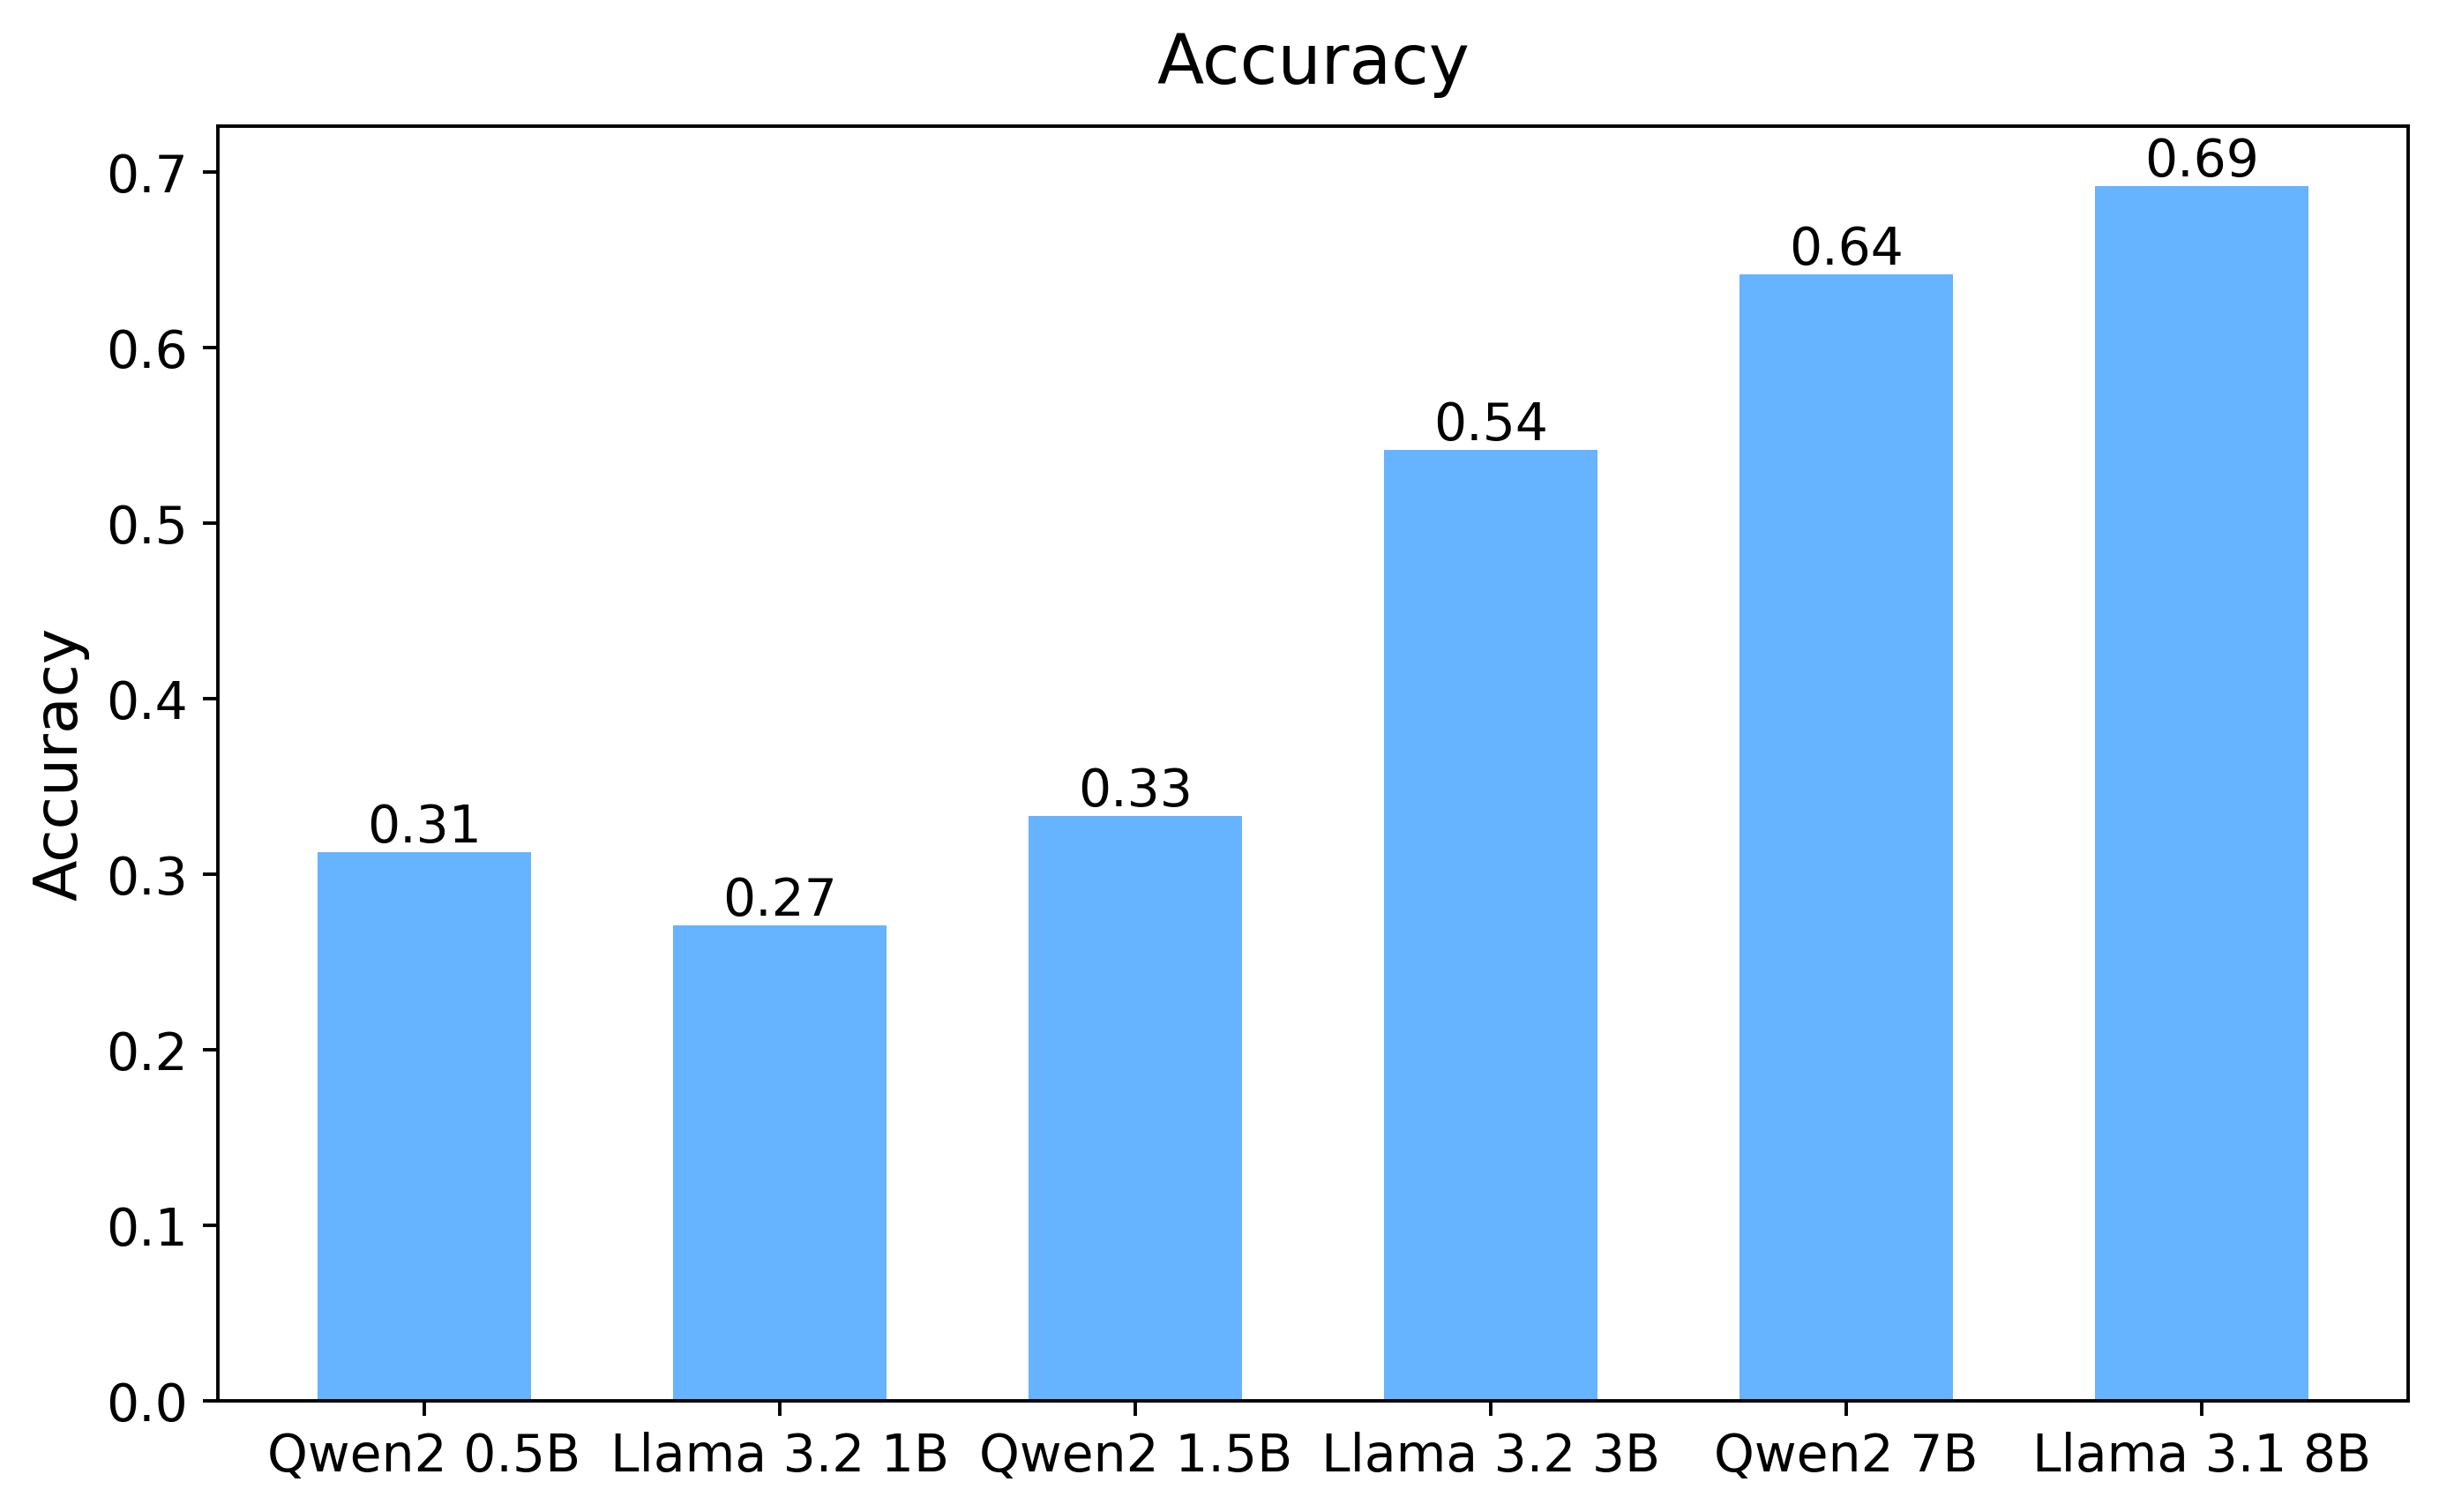

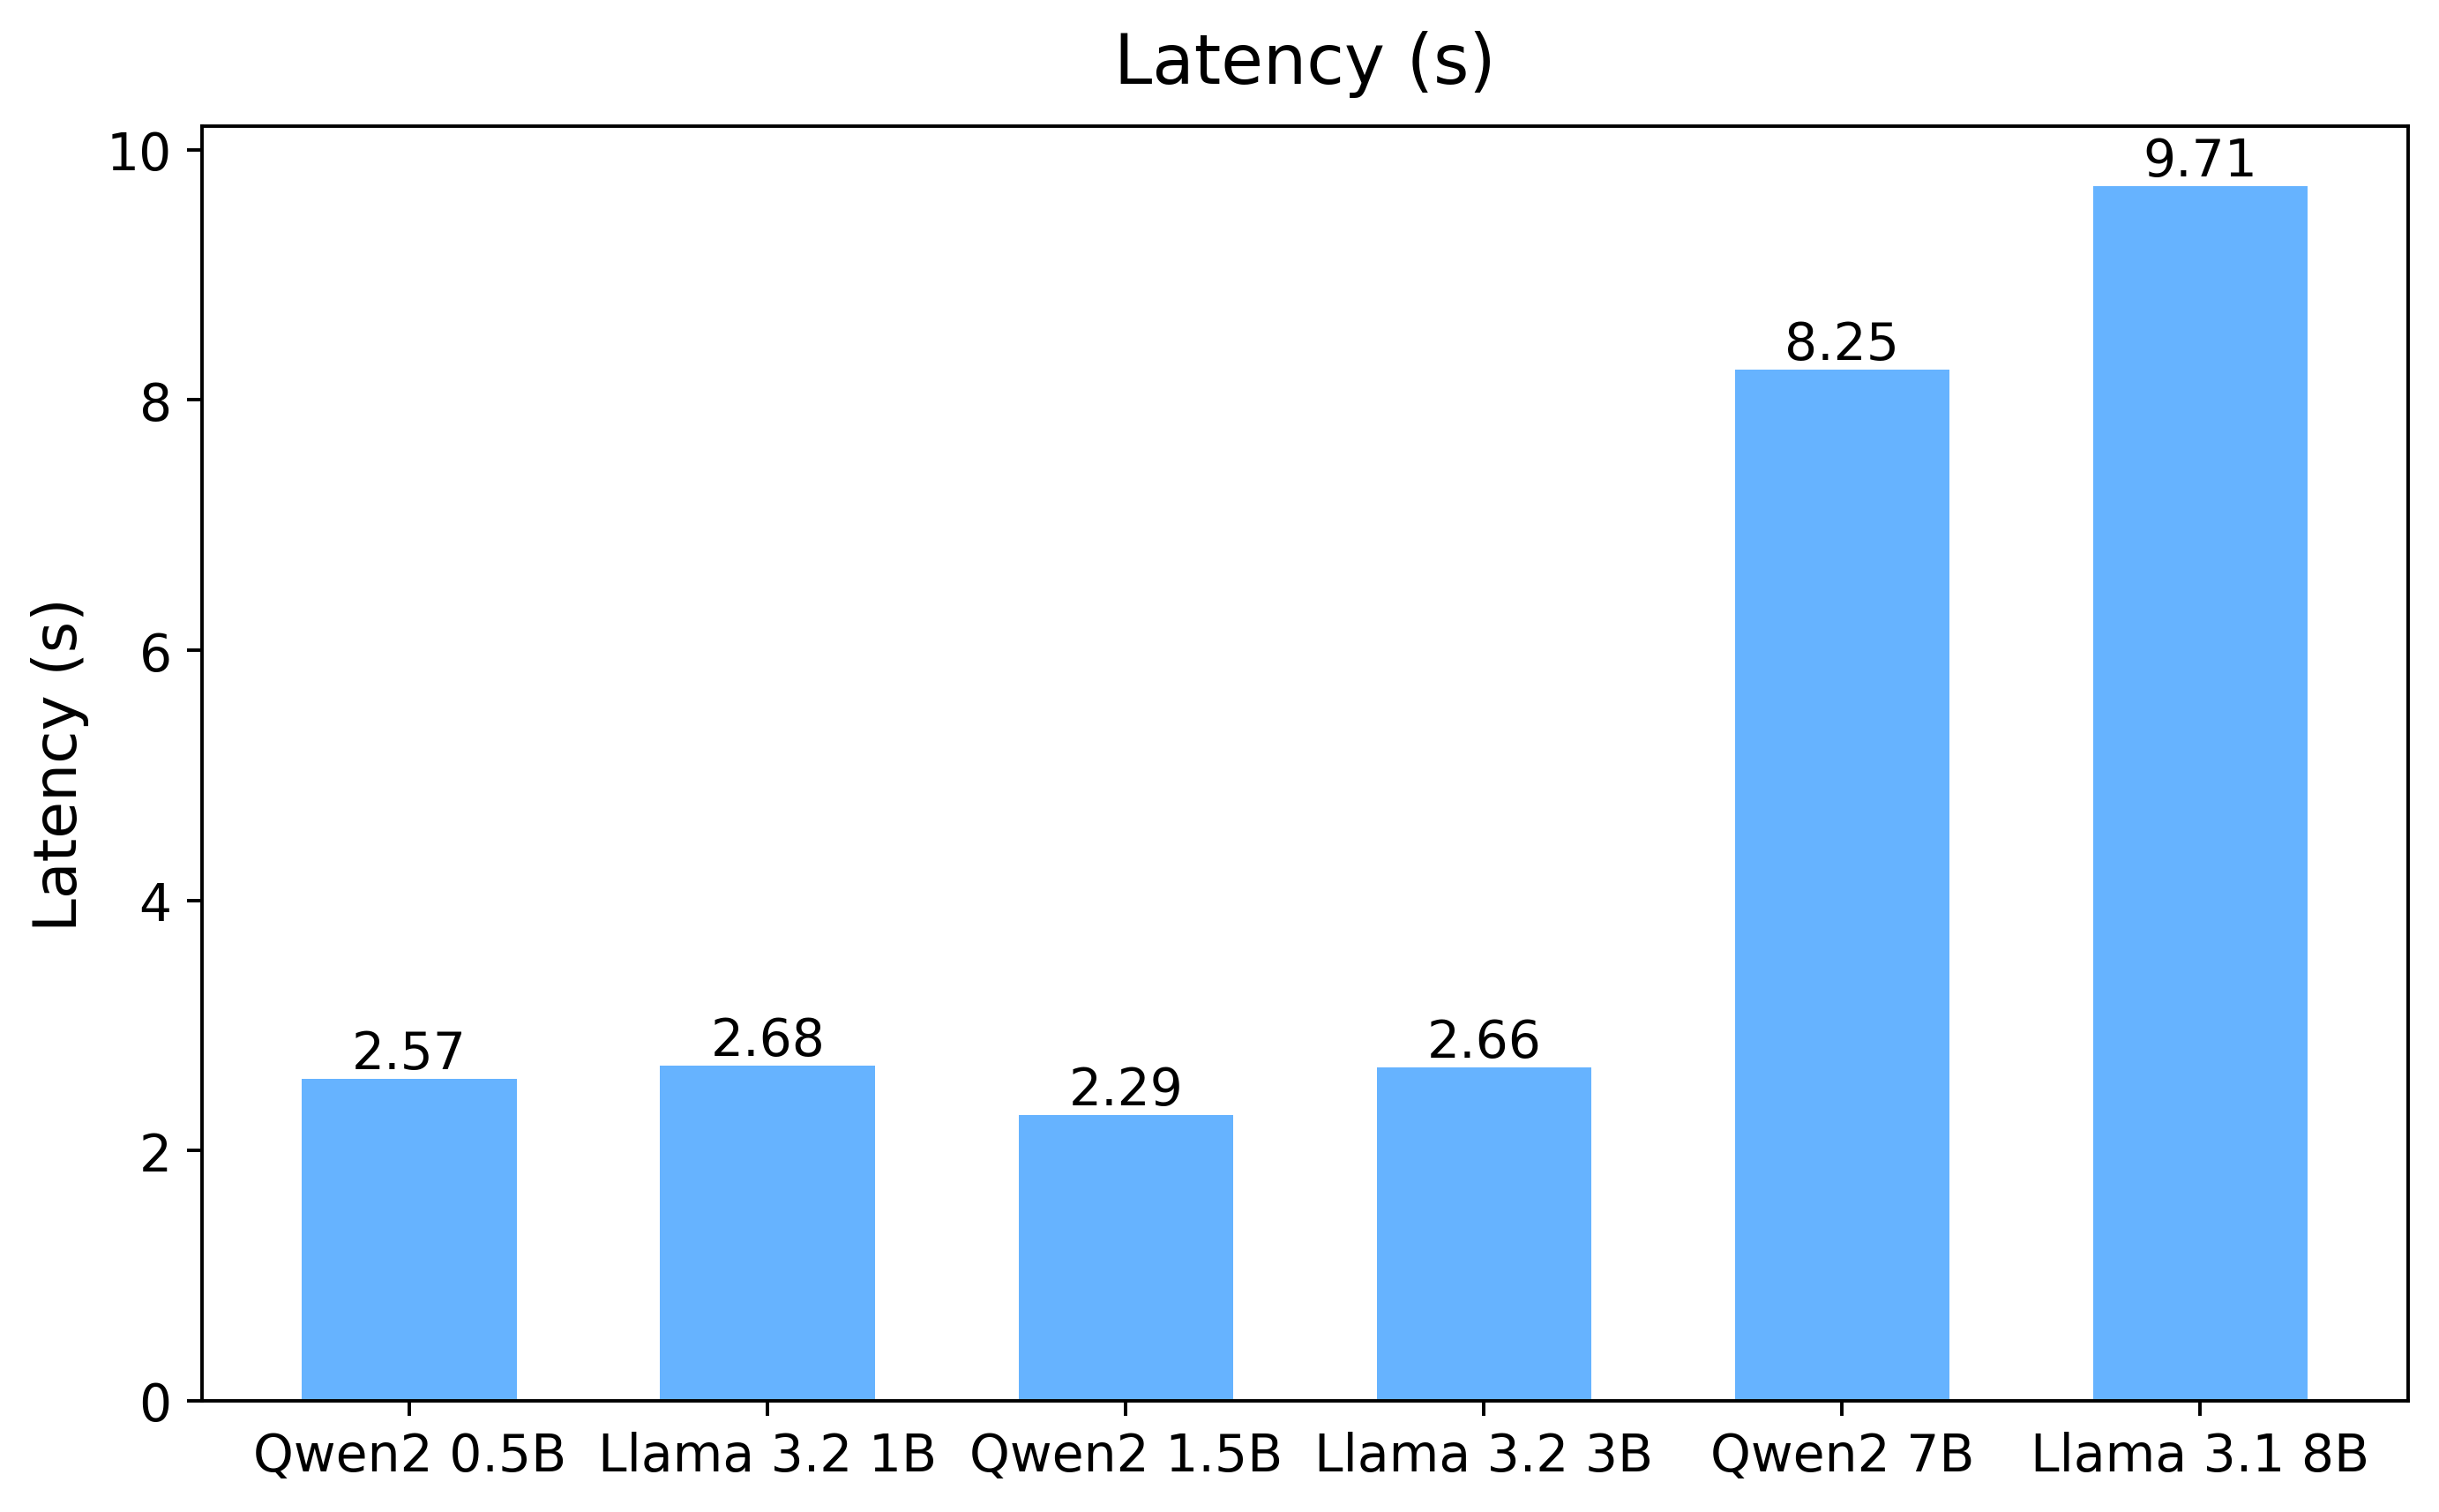

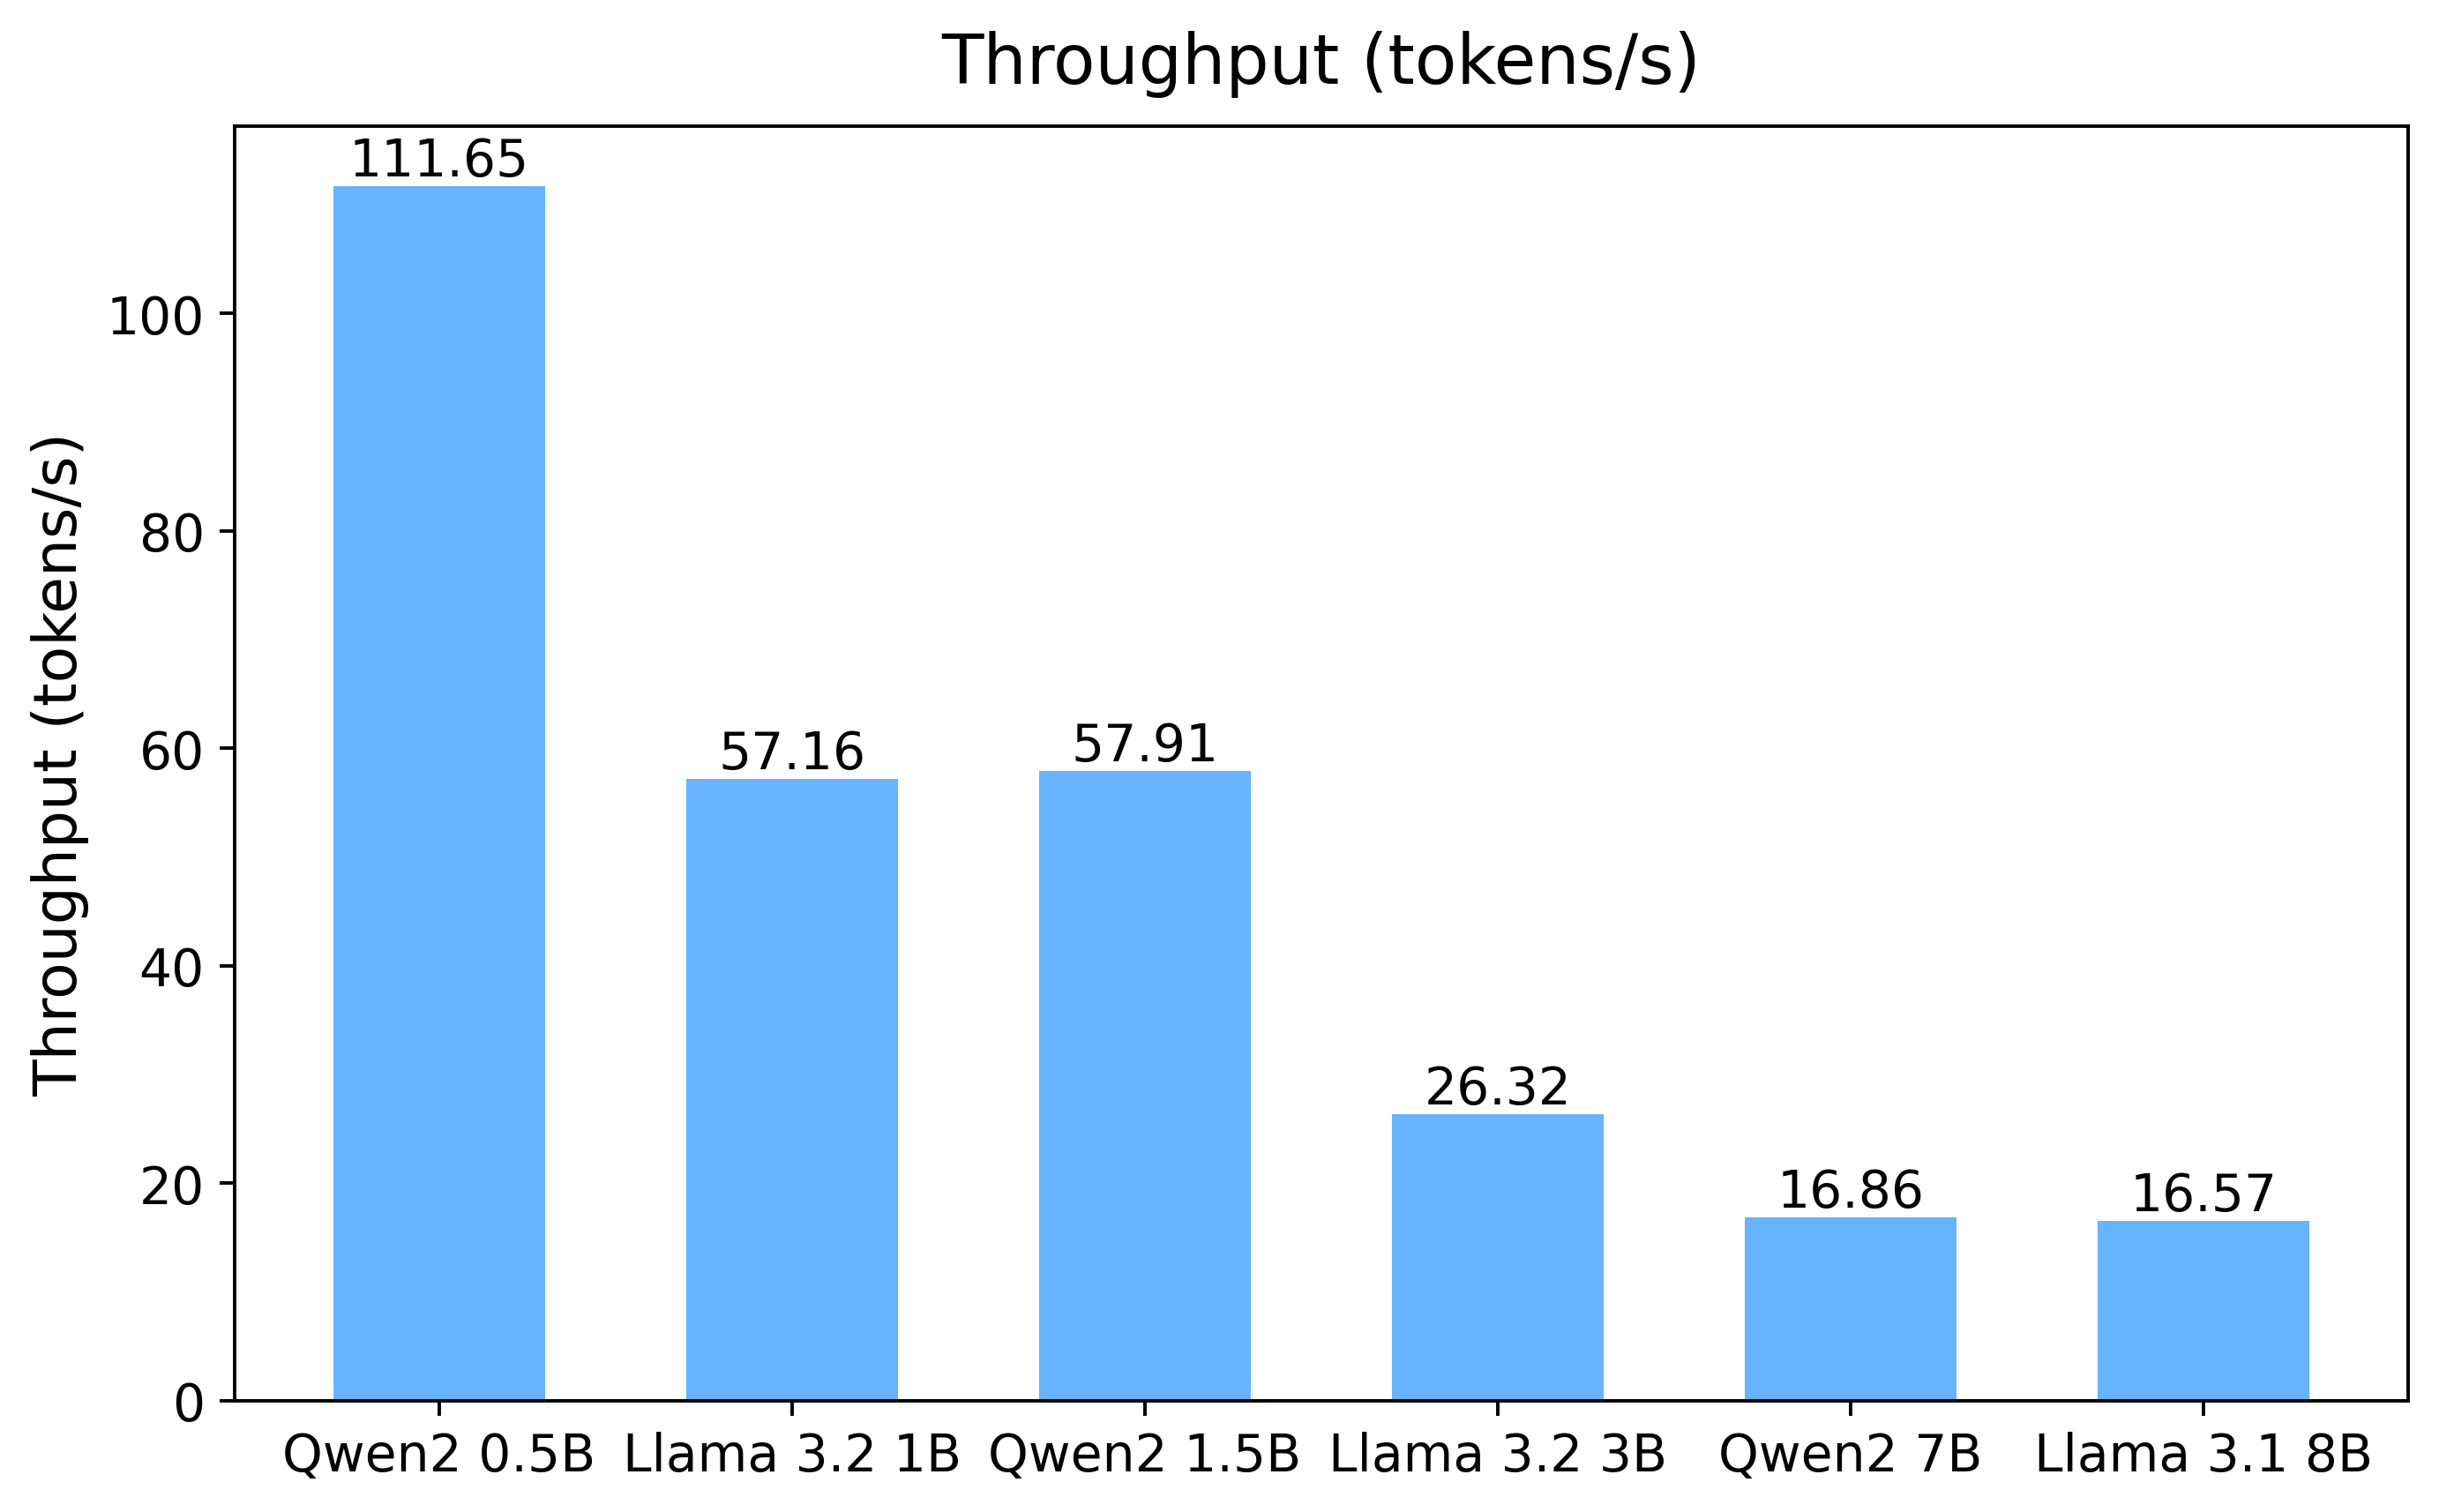

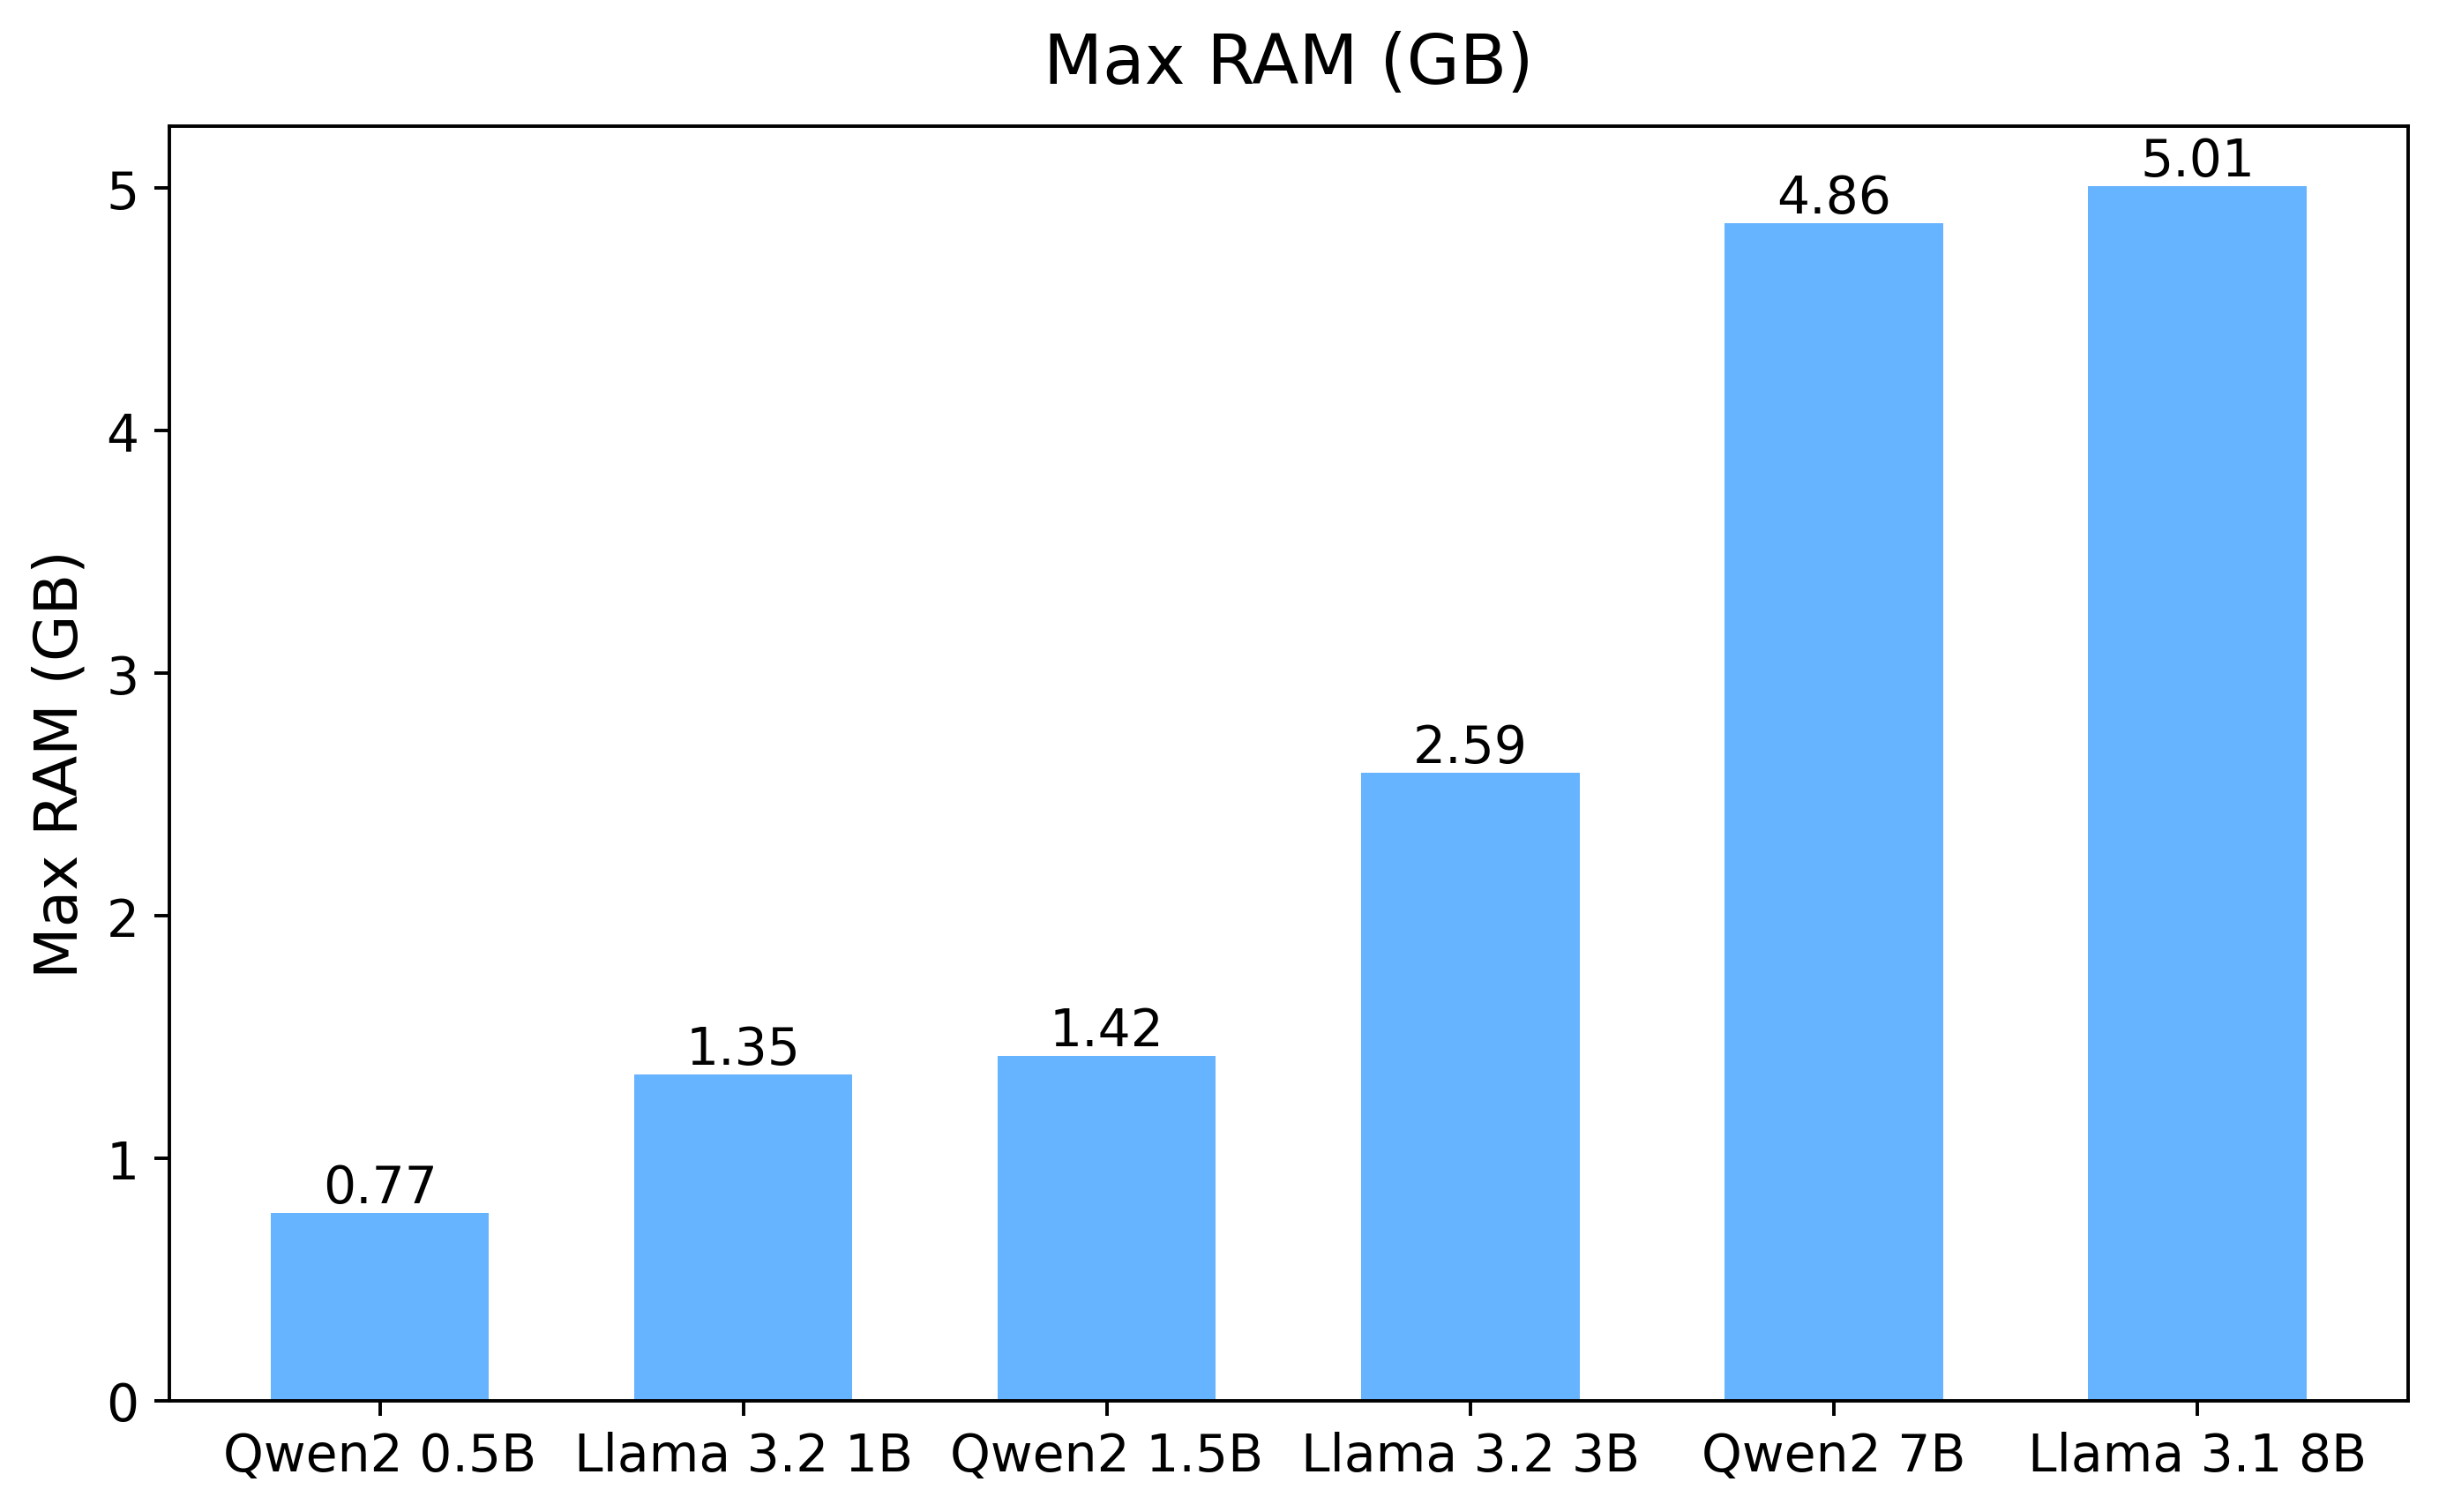

In [32]:
model_names = [
    'Qwen2 0.5B',
    'Llama 3.2 1B',
    'Qwen2 1.5B',
    'Llama 3.2 3B',
    'Qwen2 7B',
    'Llama 3.1 8B',
]

metrics = ['Accuracy', 'Latency', 'Throughput', 'Max RAM']
units = ["", "s", "tokens/s", "GB"]
plot_model_metrics(model_names, metrics, units, final_model_results)

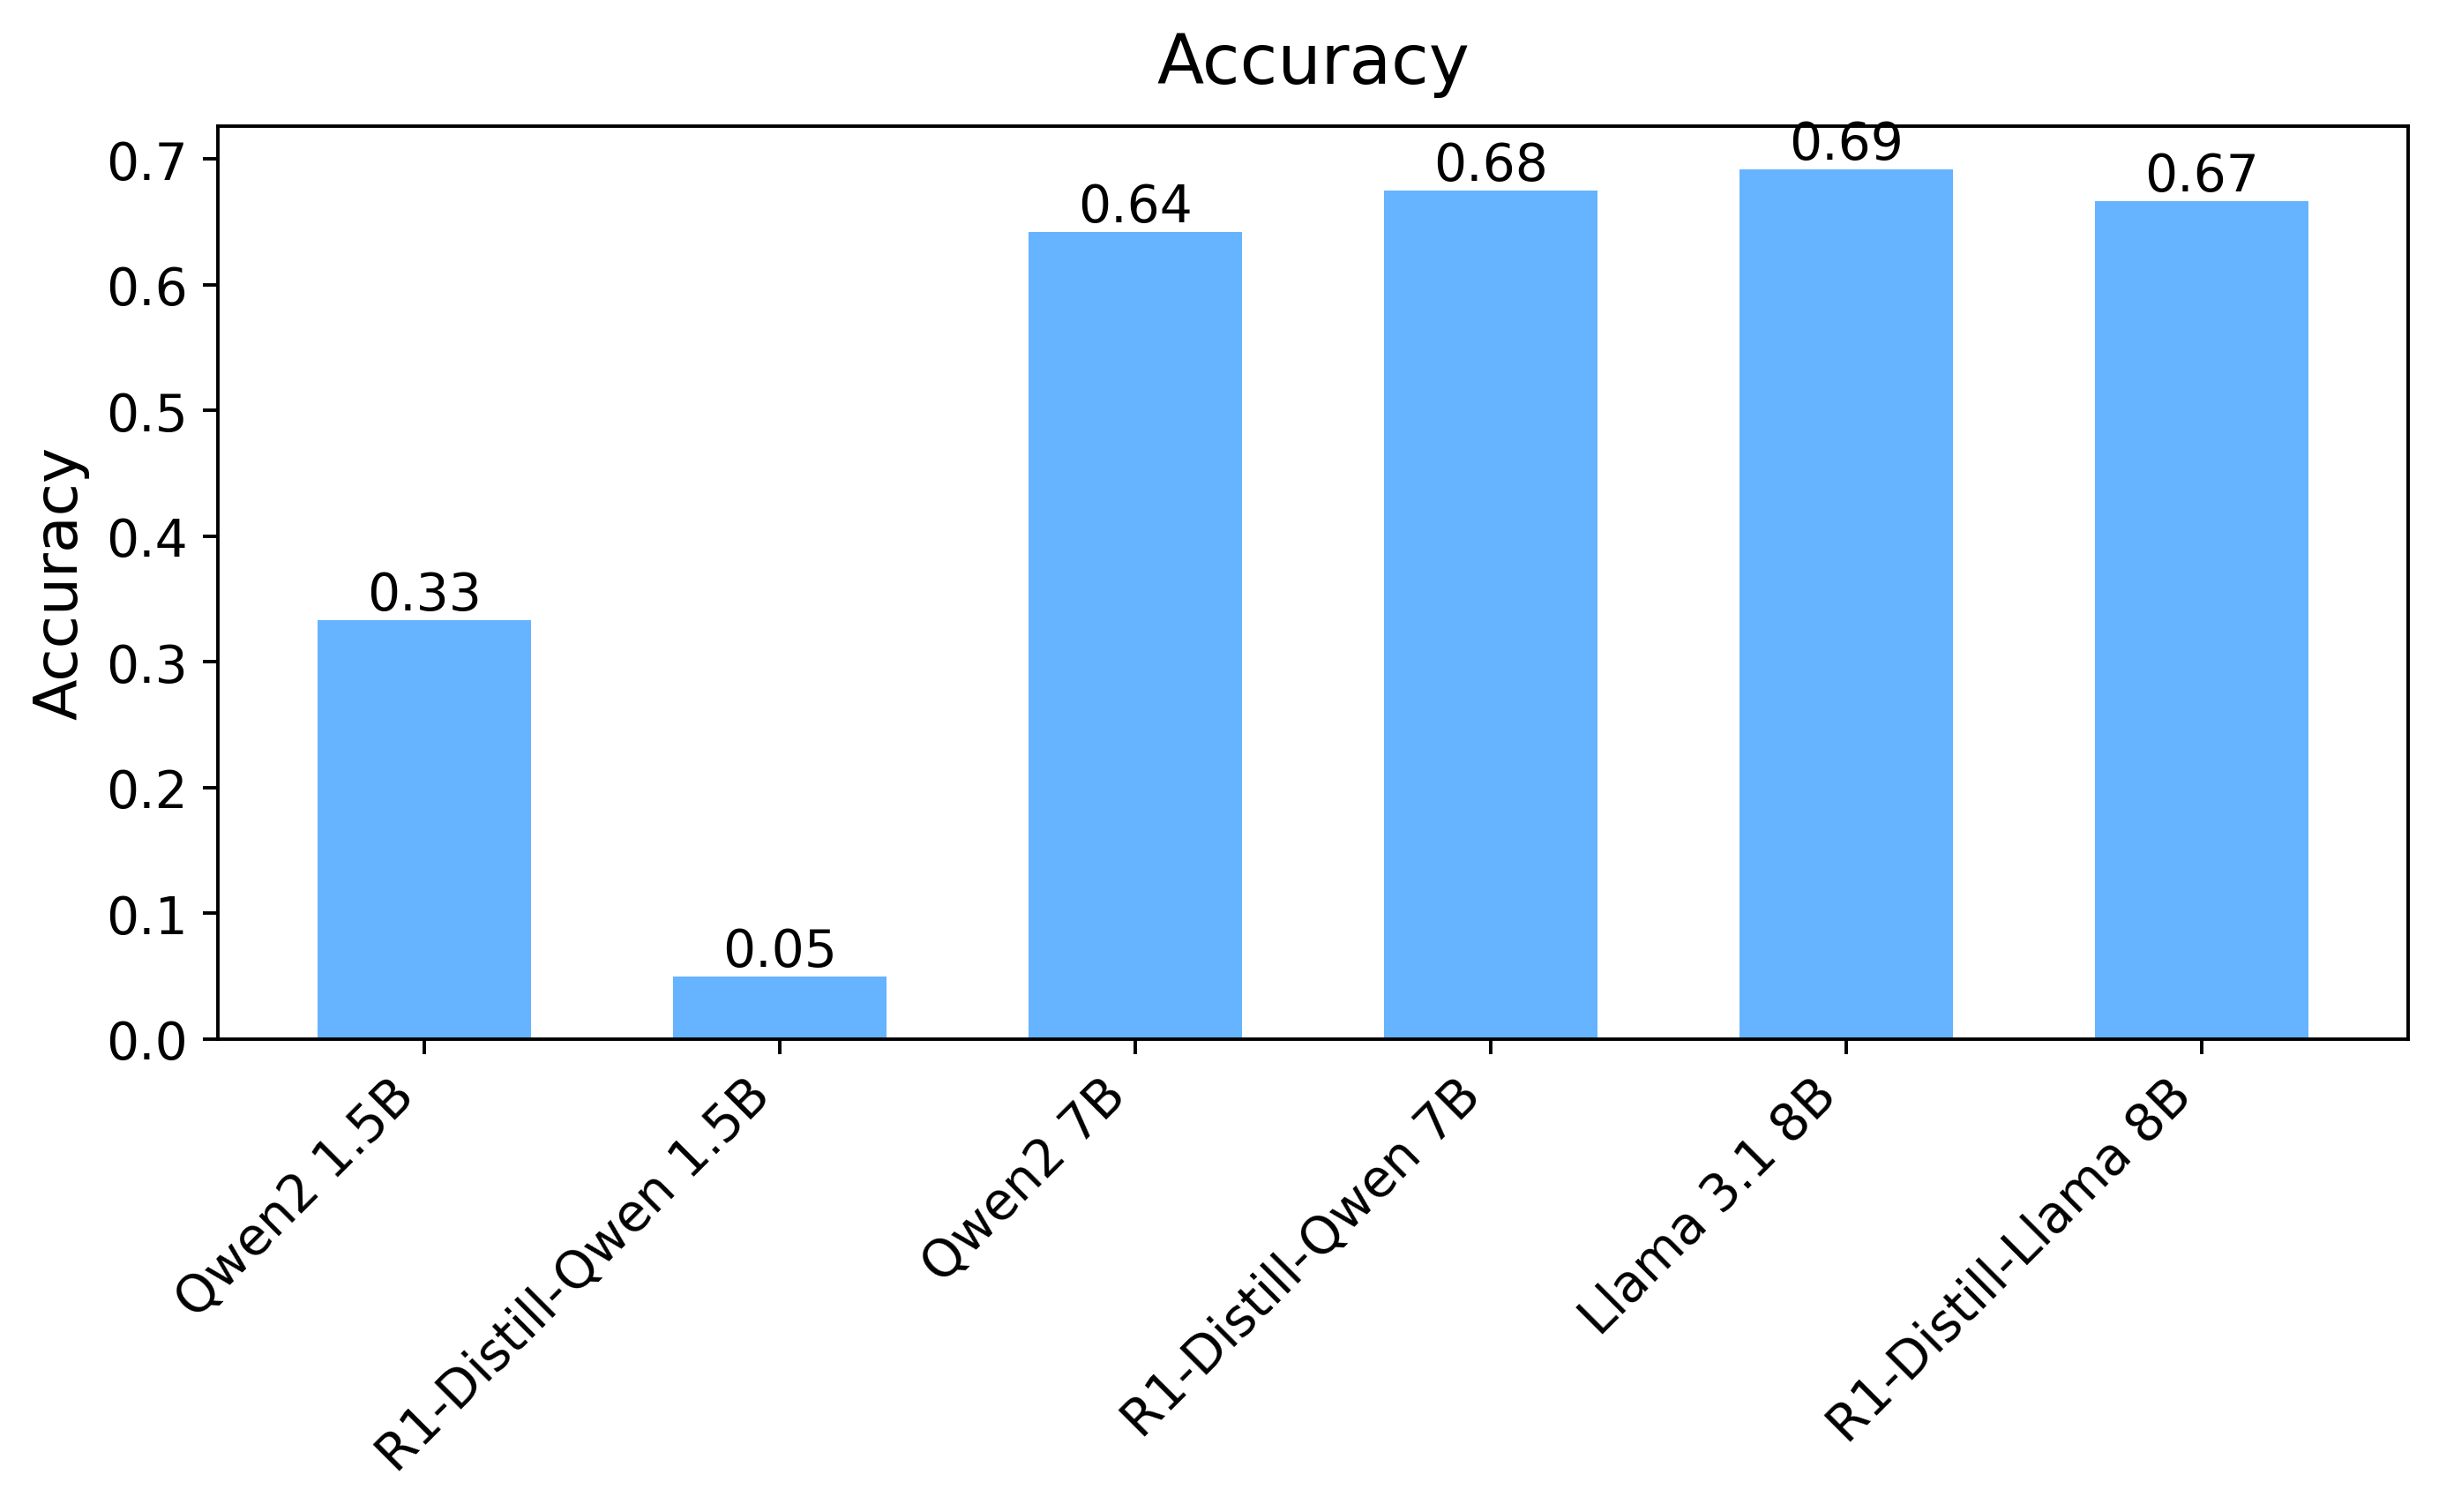

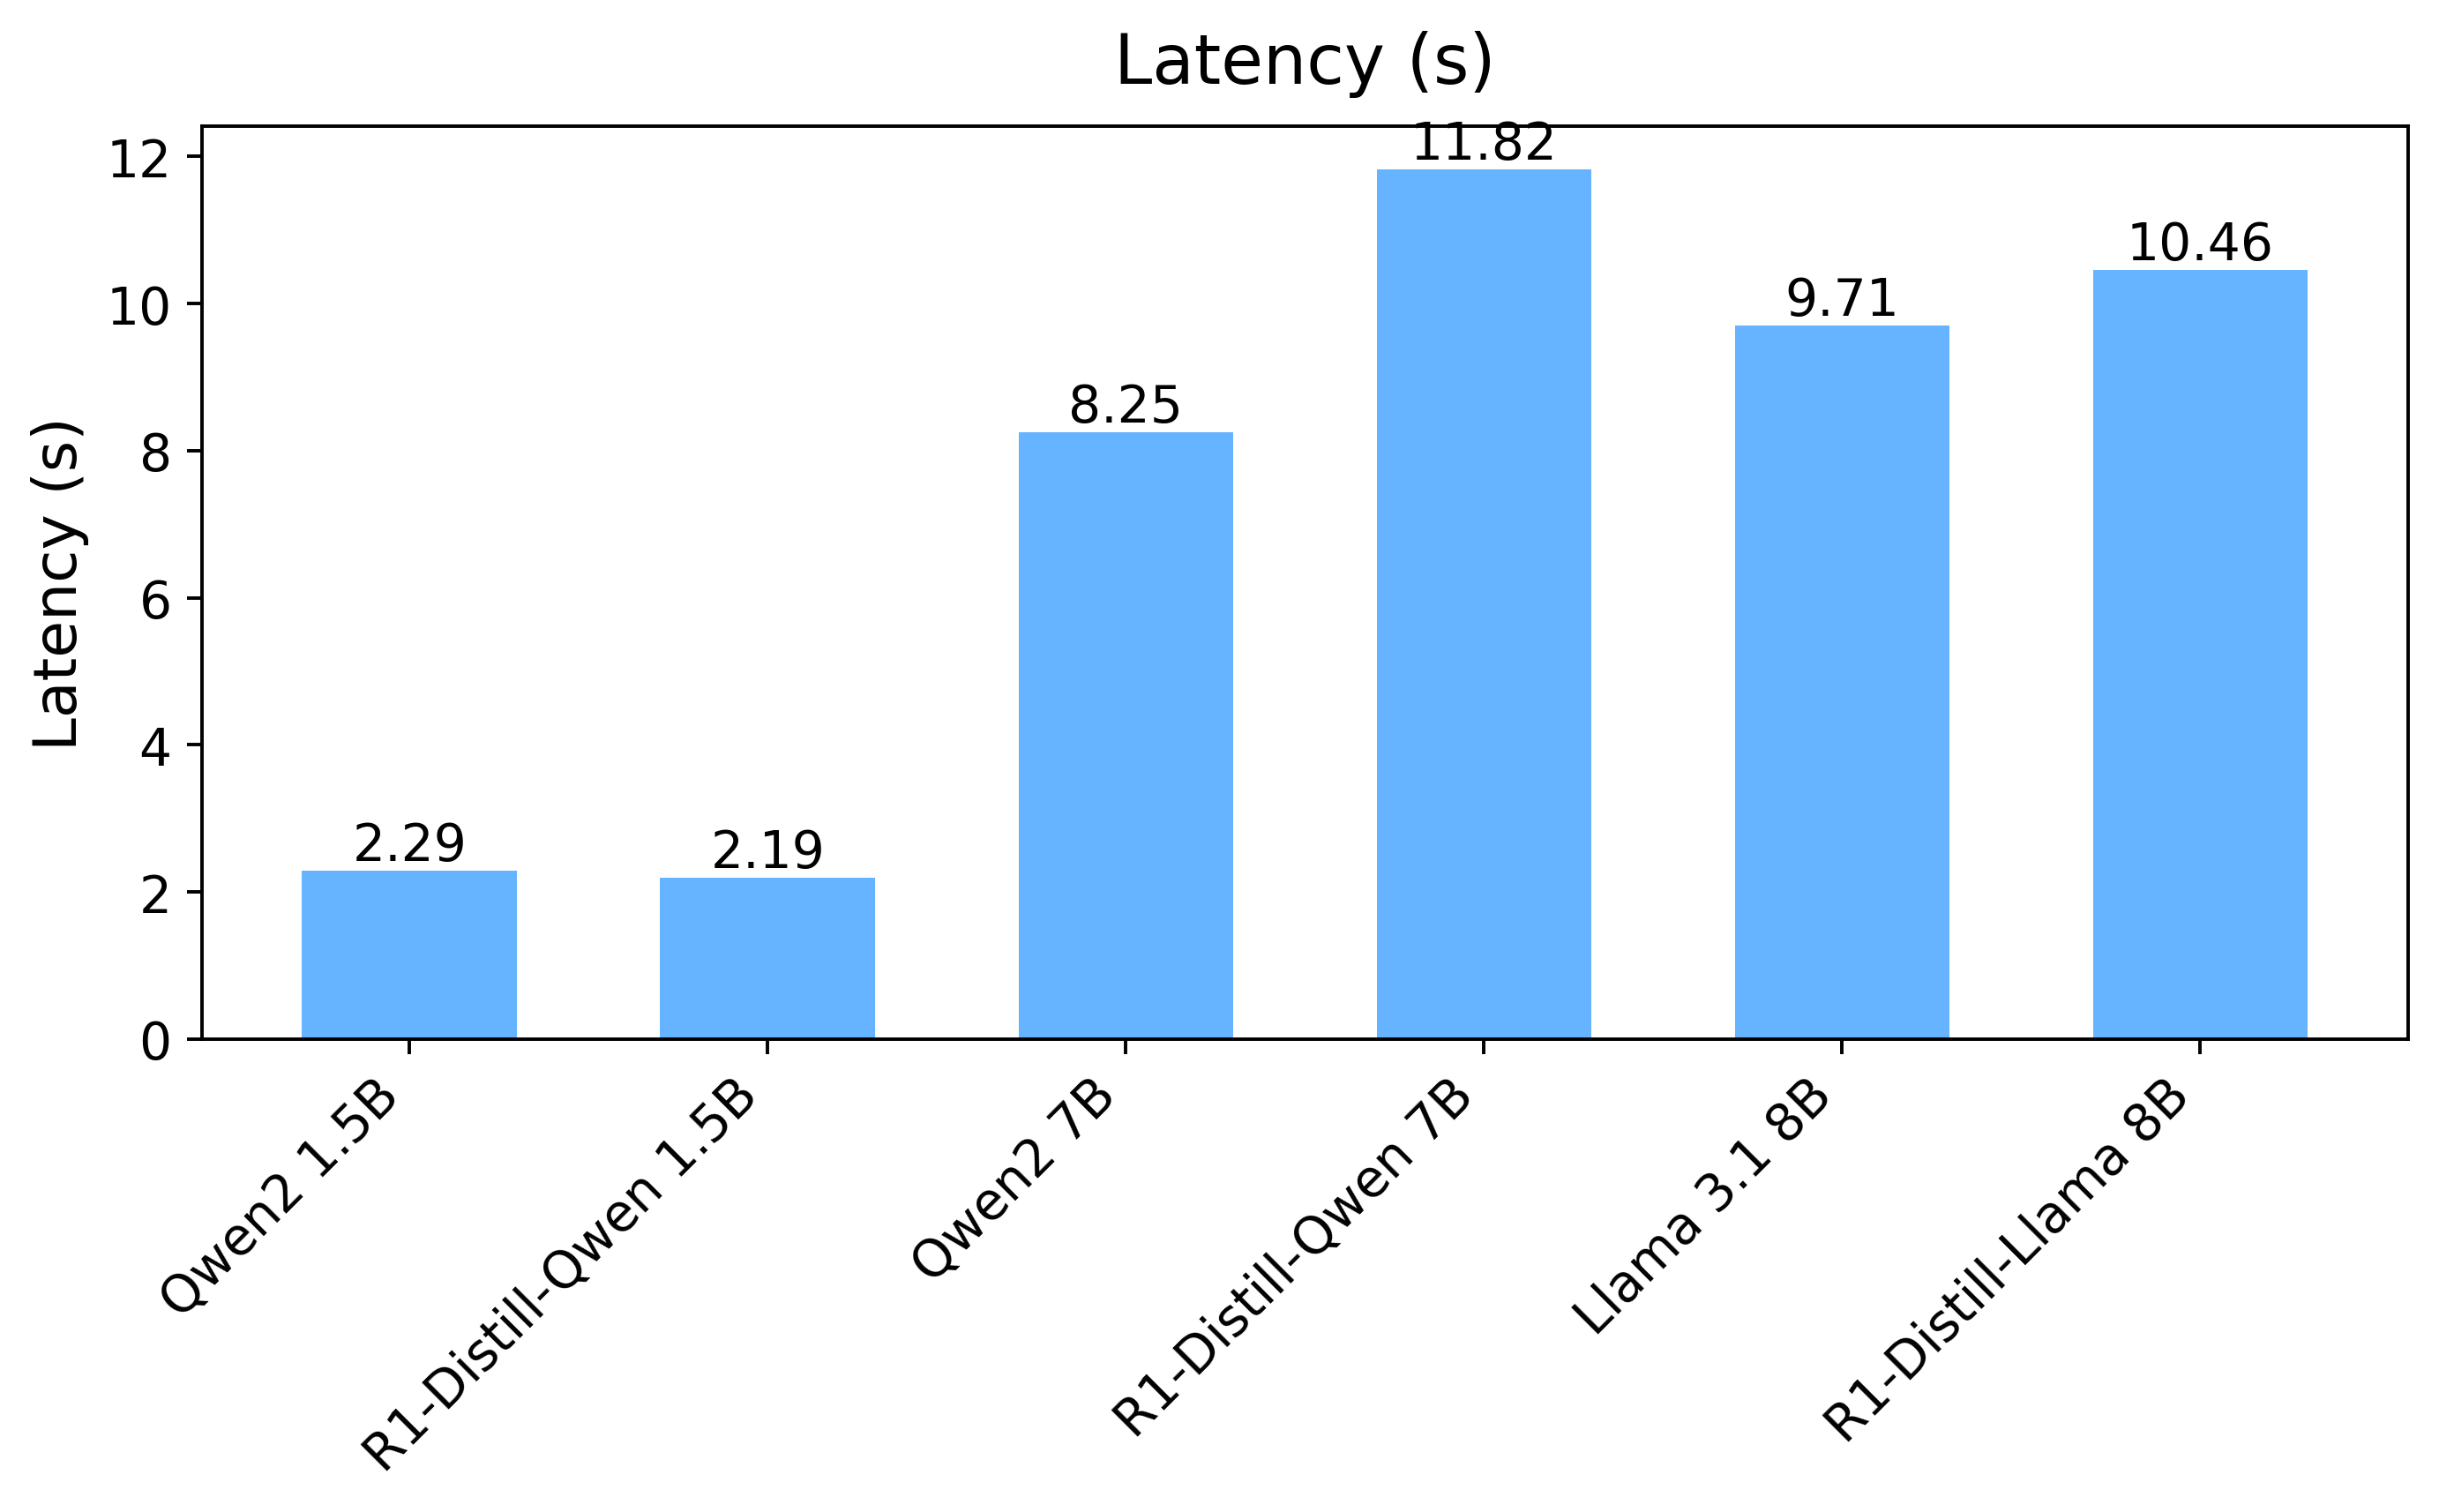

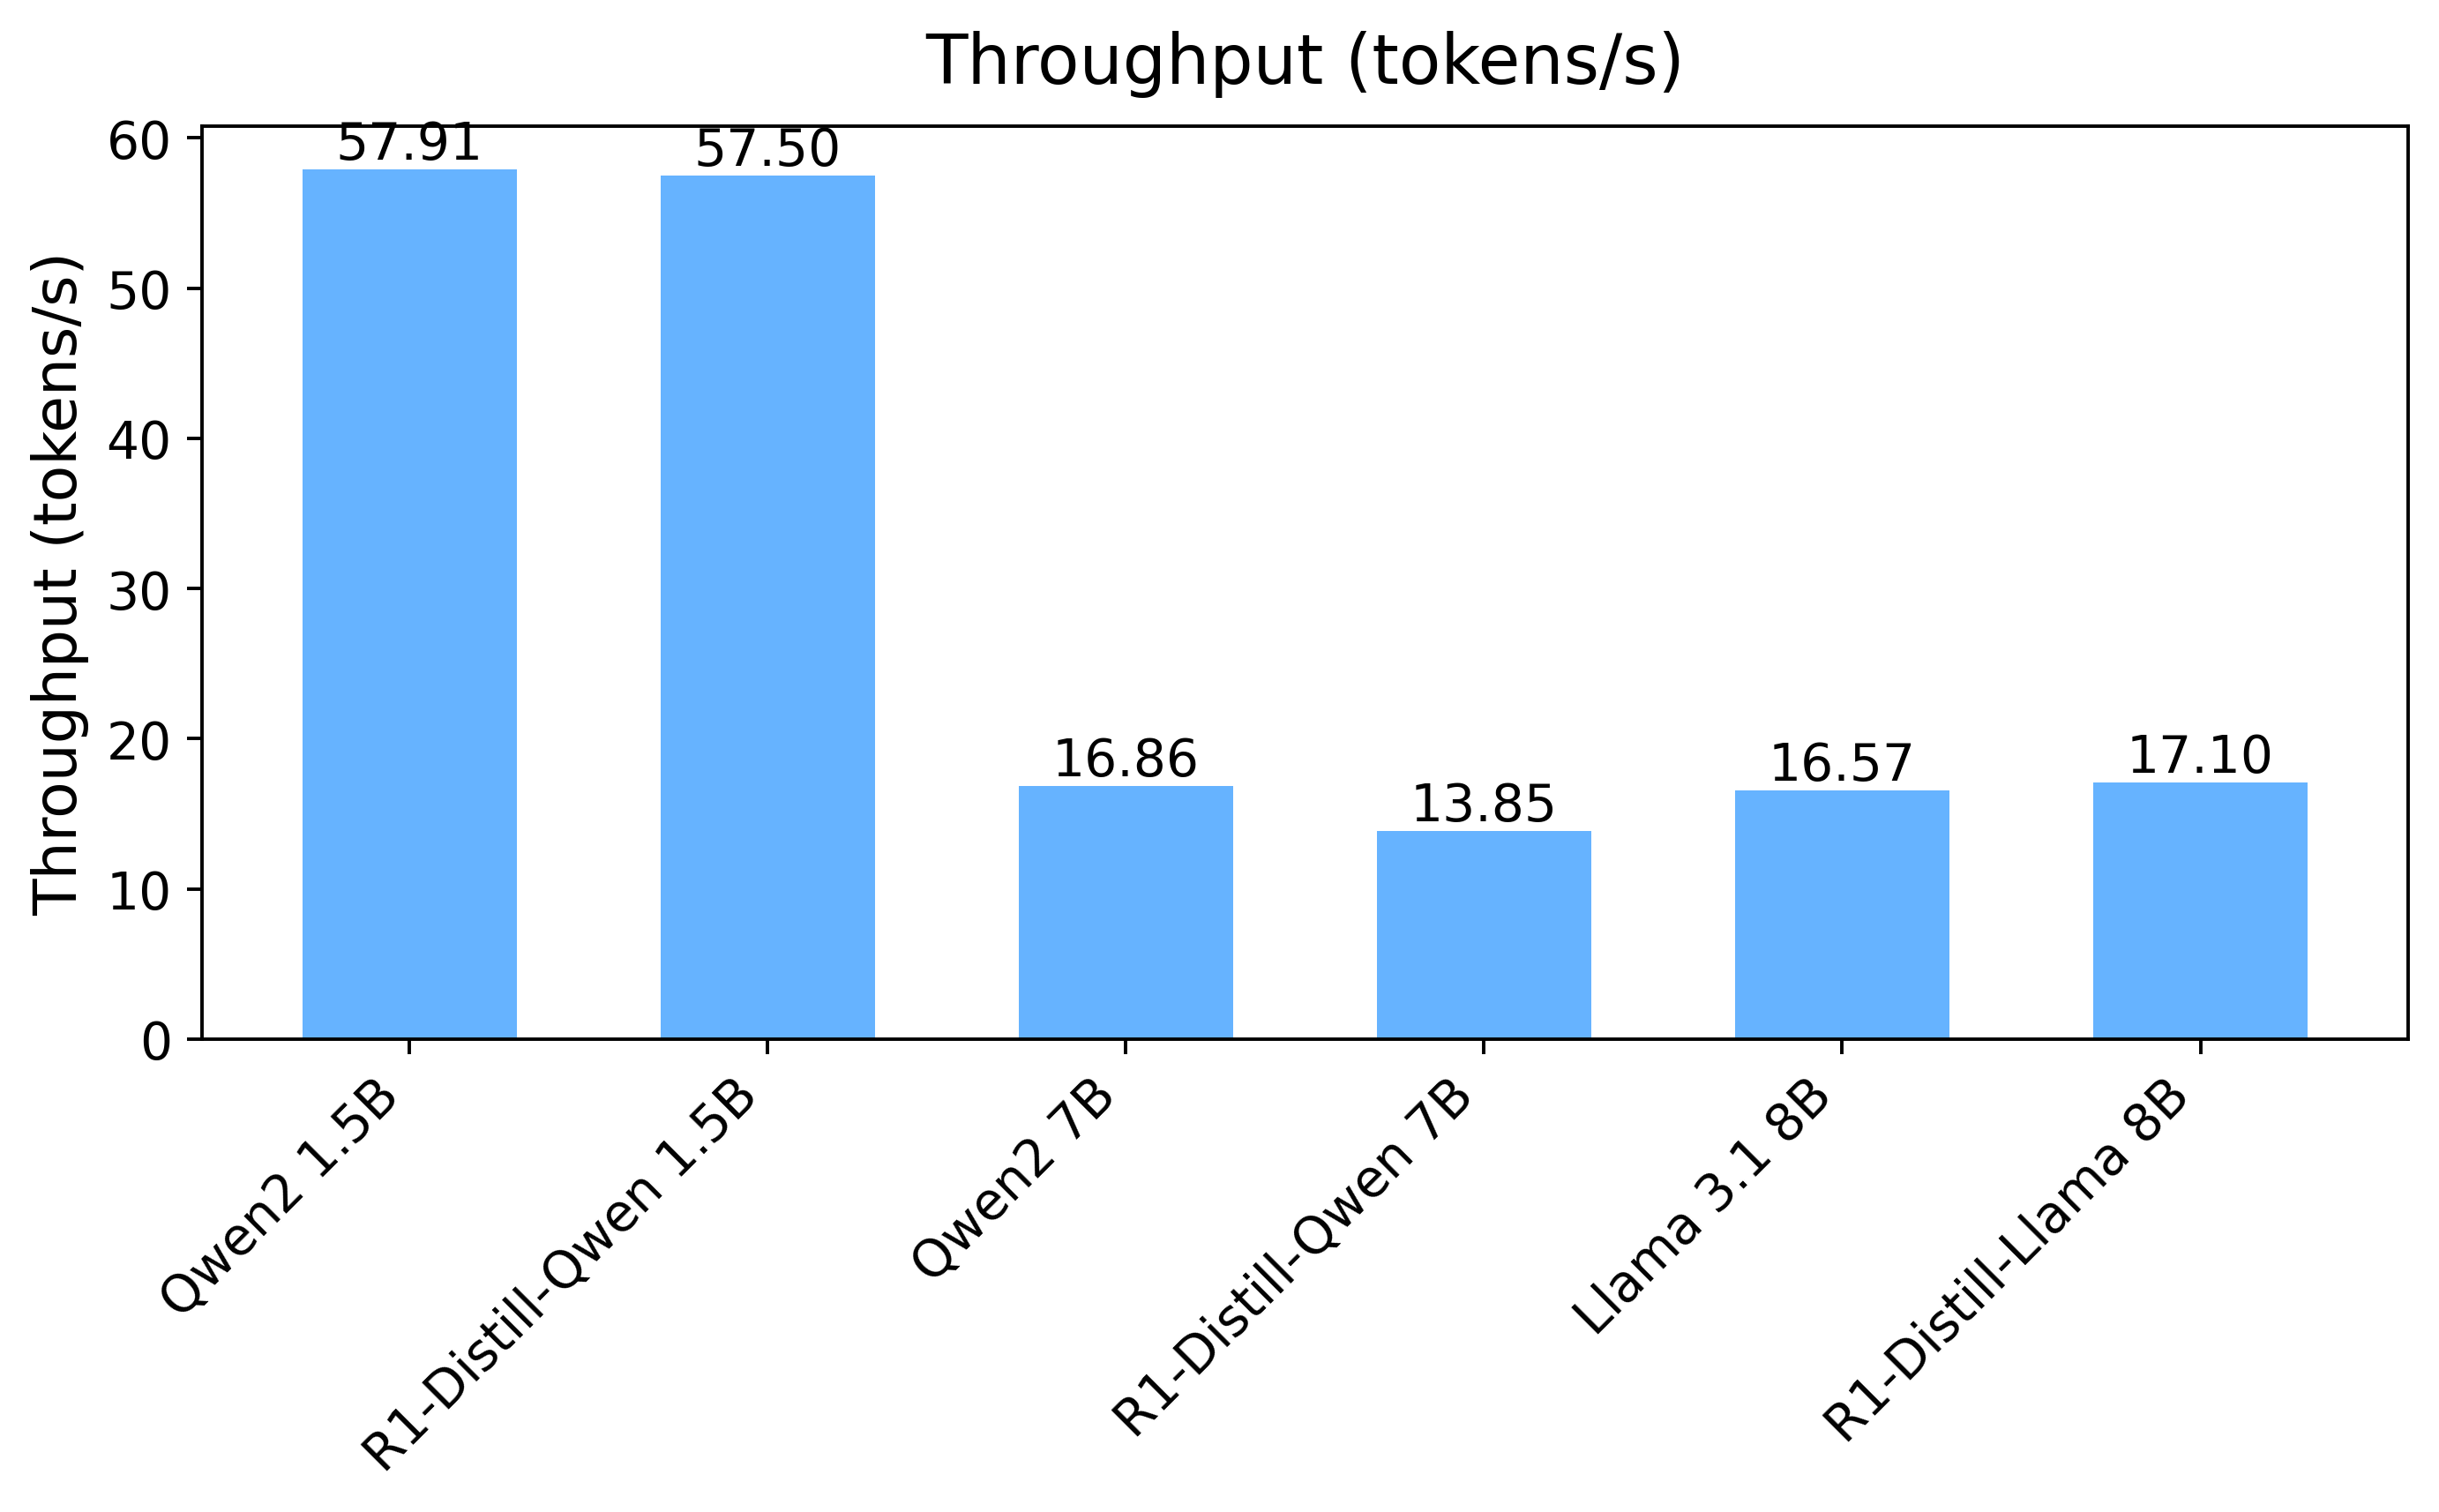

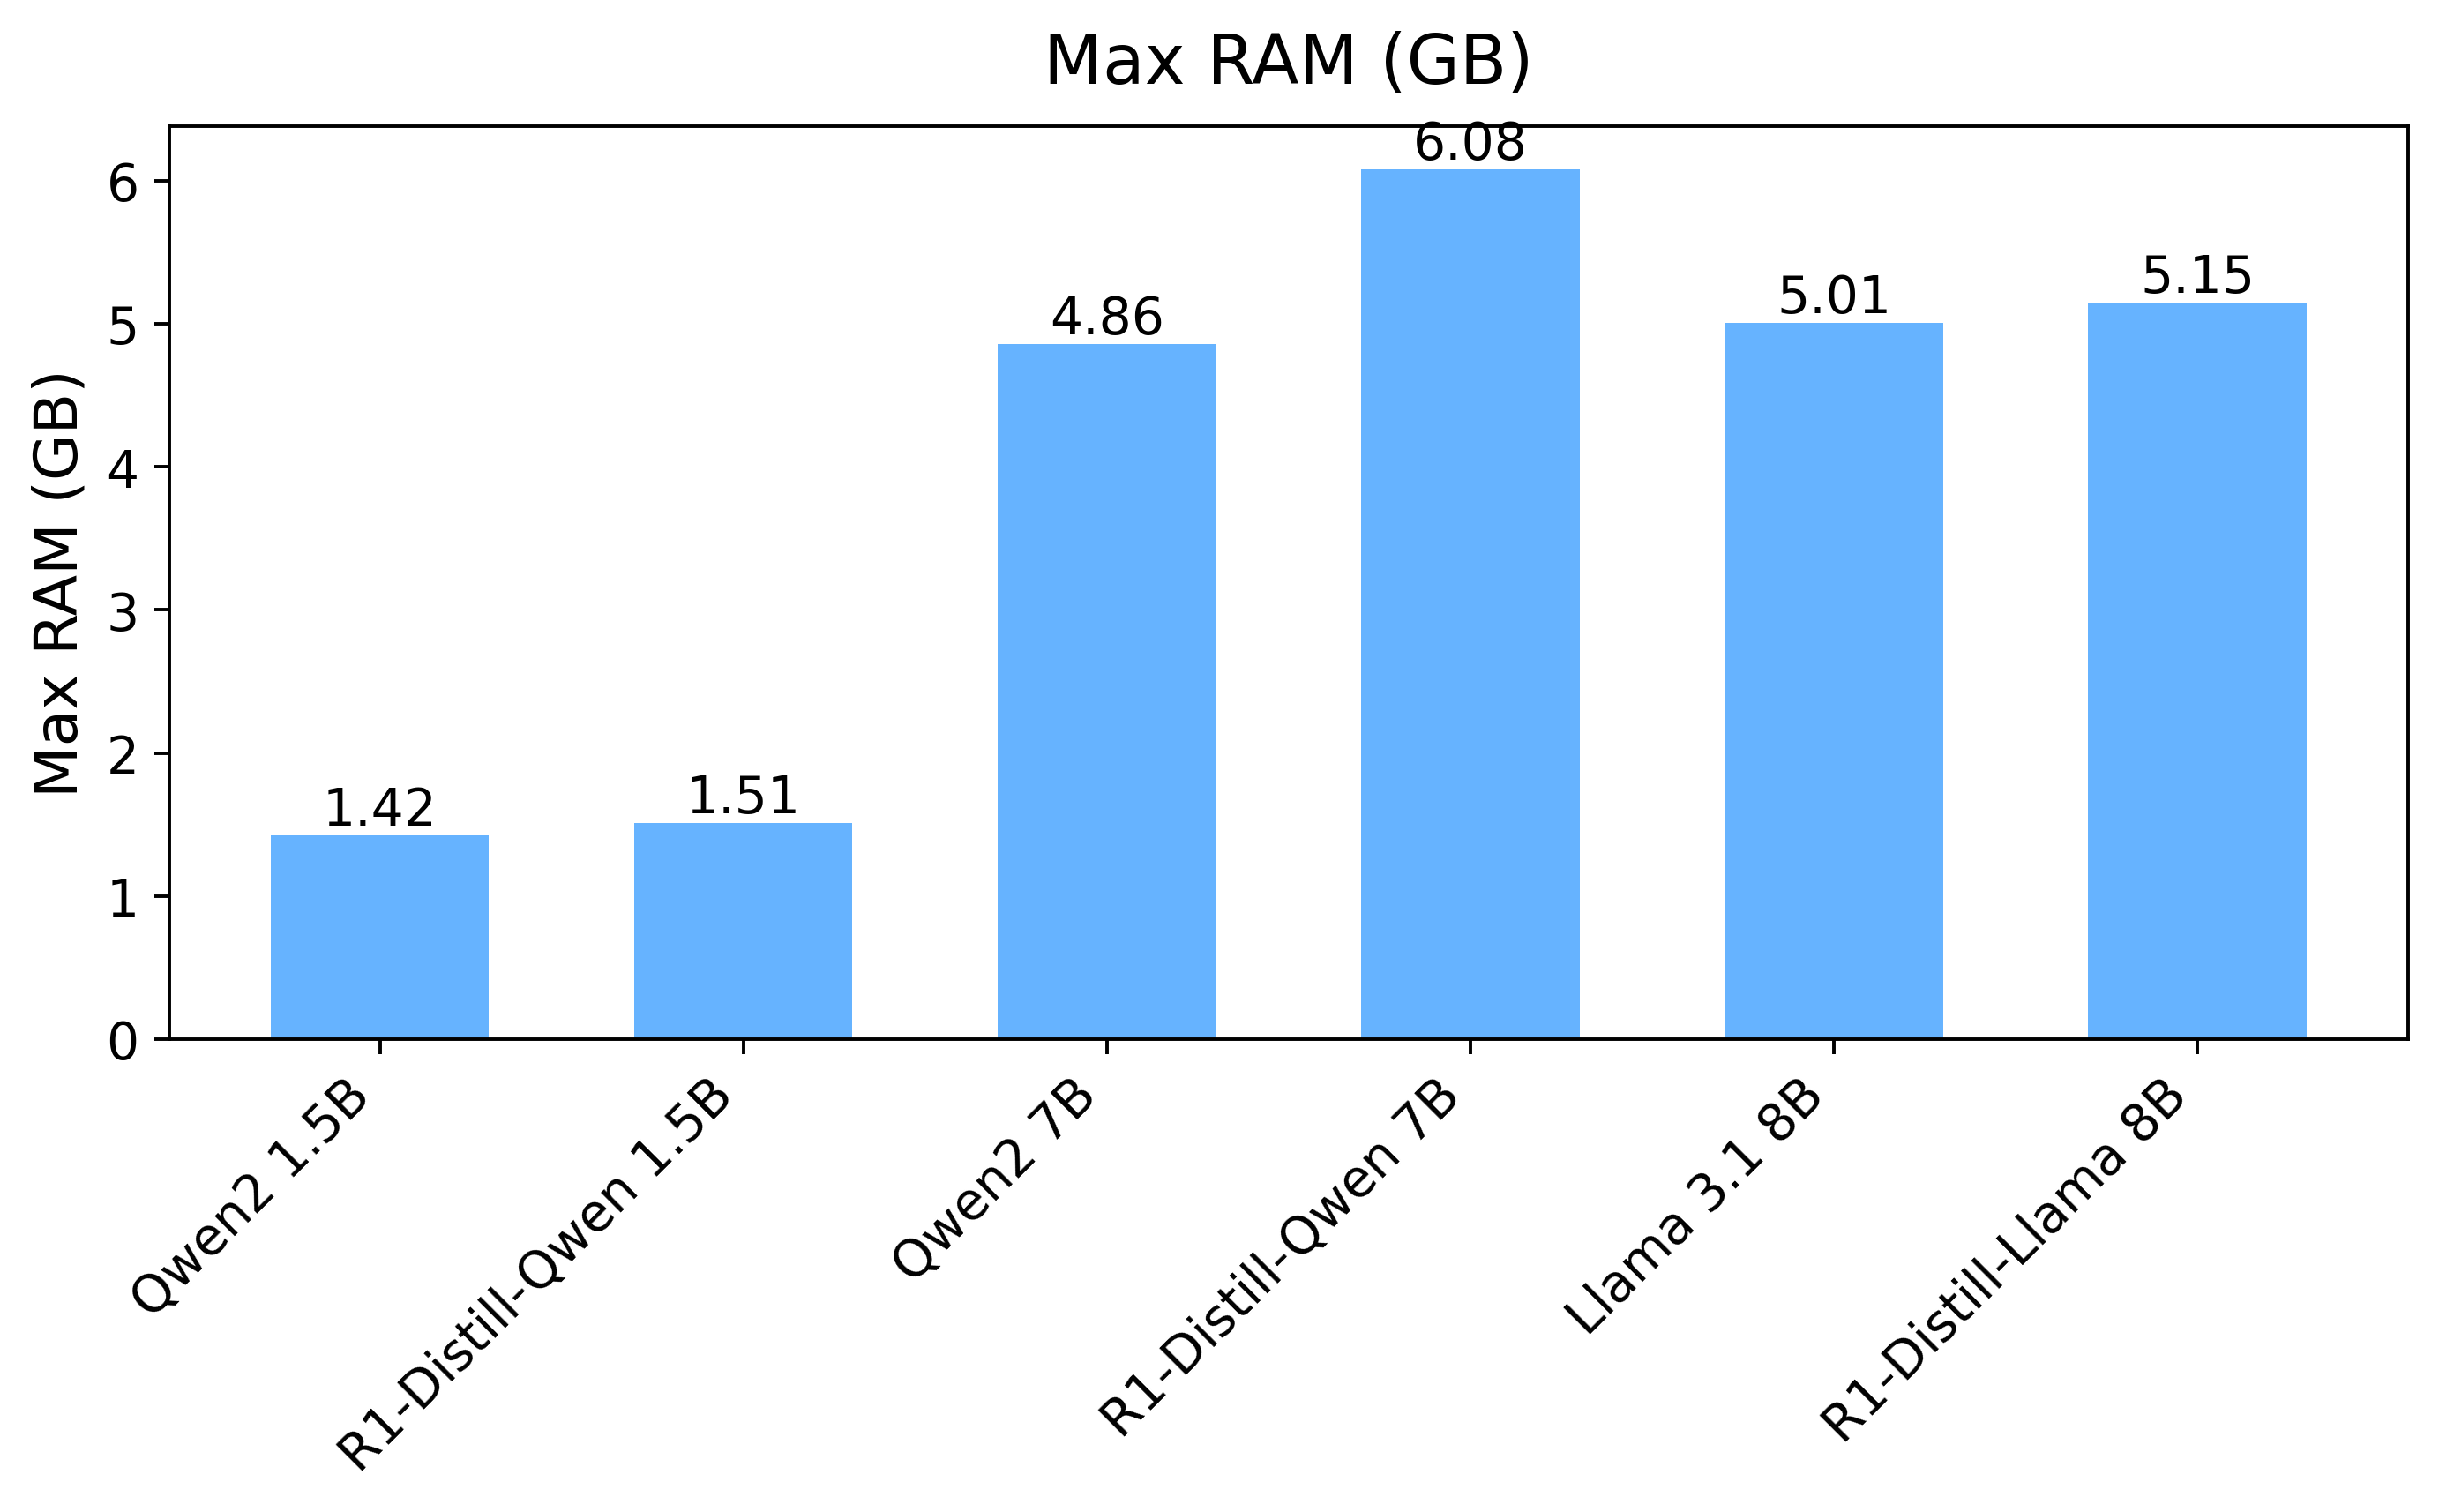

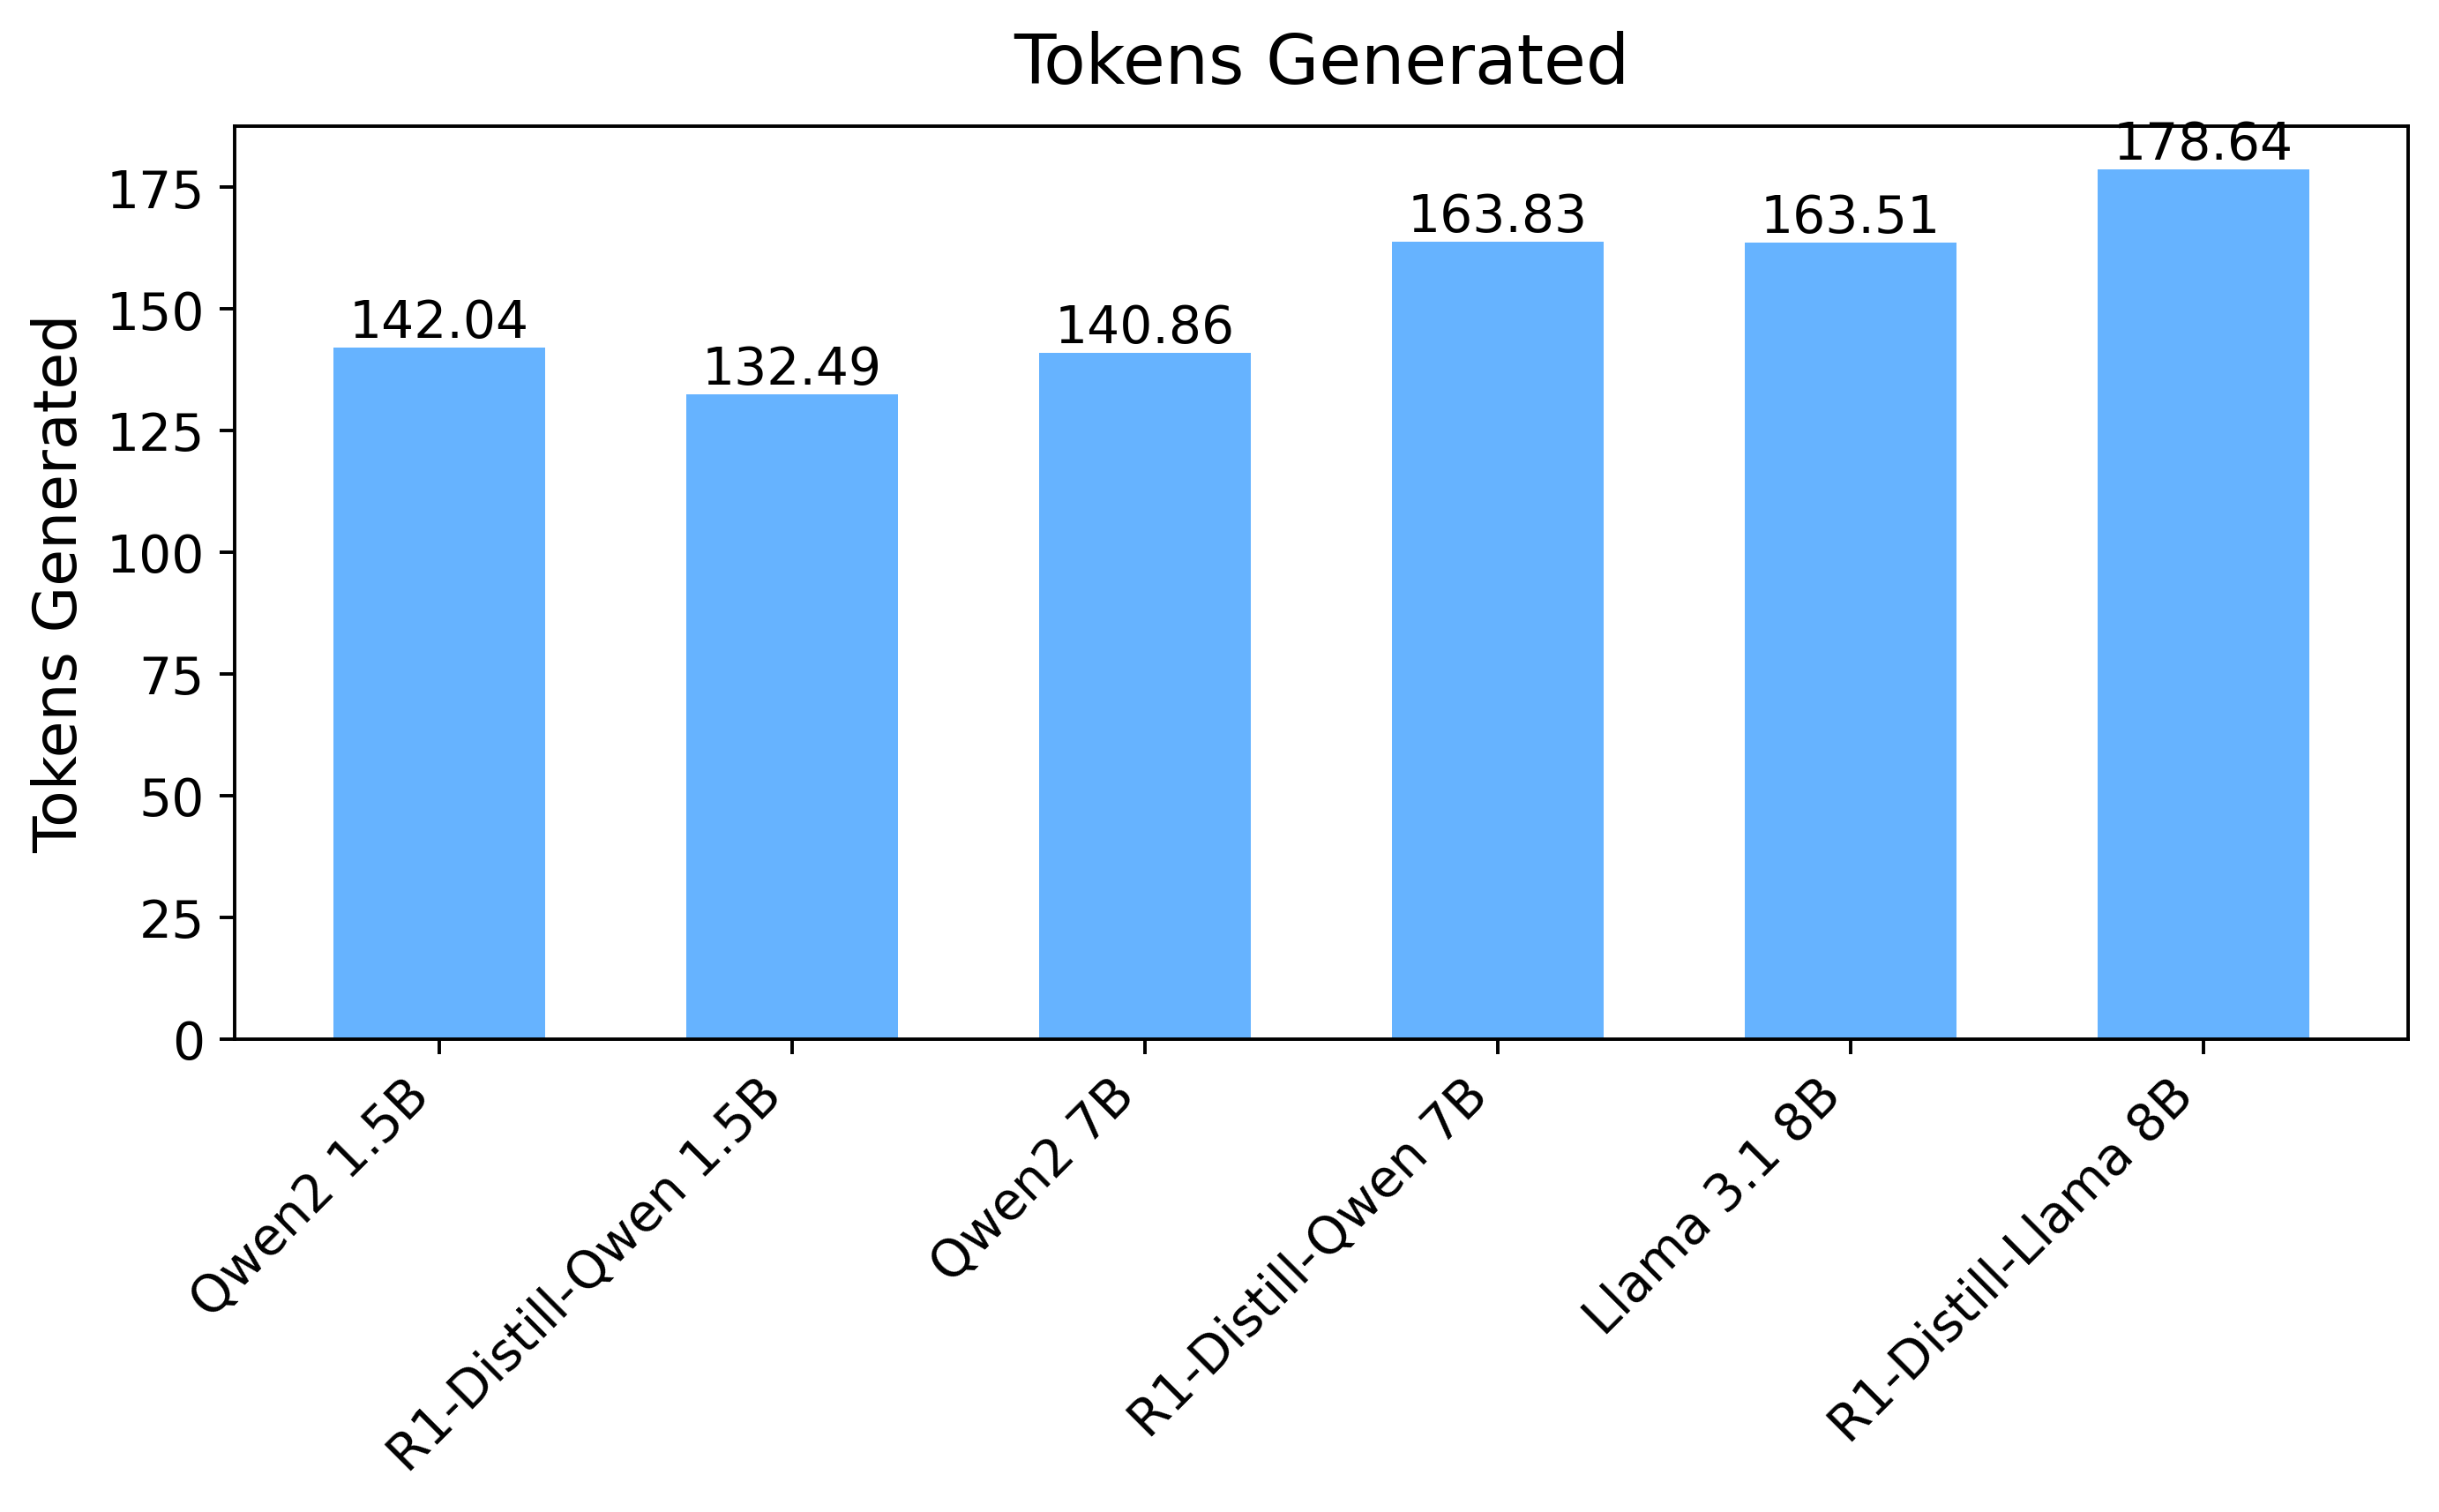

In [33]:
def plot_model_metrics(model_names, metrics, units, model_data):
    """
    Plots bar graphs for each metric across the provided model names.

    Parameters:
    - model_names: list of str, the names of the models to include.
    - metrics: list of str, the metrics to plot (e.g., 'Latency', 'Throughput').
    - units: list of str, the corresponding units for each metric.
    - model_data: dict, where keys are model names and values are dictionaries 
                  containing the metric values.
    """
    
    for metric, unit in zip(metrics, units):
        # Extract metric values for the models (ignore models missing the metric)
        unit_str = f" ({unit})" if unit else ""
        values = []
        selected_models = []
        for model in model_names:
            if model in model_data and metric in model_data[model]:
                values.append(model_data[model][metric])
                selected_models.append(model)

        # Create a new figure for each metric with 350 dpi for publication quality
        plt.figure(figsize=(8, 5), dpi=350)

        # Plot bars with a custom color, bar width, and edge color
        bars = plt.bar(
            selected_models, 
            values, 
            color='#66b3ff',   # Light blue
            width=0.6         # Adjust as needed for thickness
        )
        
        # Add a title and axis labels with increased font sizes
        plt.title(f"{metric}{unit_str}", fontsize=16, pad=10)
        # plt.xlabel("Models", fontsize=14)
        plt.ylabel(f"{metric}{unit_str}", fontsize=14)

        # Rotate x-axis labels for clarity with increased font size
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)

        # Add numeric labels on top of each bar with increased font size
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # X position in center of bar
                height,                            # Y position just above the bar
                f"{height:.2f}",                   # Format to 2 decimal places
                ha='center', va='bottom', 
                fontsize=12
            )
        
        # Make layout fit nicely
        plt.tight_layout()
        plt.show()





model_names = [
    'Qwen2 1.5B',
    'R1-Distill-Qwen 1.5B',
    'Qwen2 7B',
    'R1-Distill-Qwen 7B',
    'Llama 3.1 8B',
    'R1-Distill-Llama 8B'
]

metrics = ['Accuracy', 'Latency', 'Throughput', 'Max RAM', 'Tokens Generated']
units = ["", "s", "tokens/s", "GB", ""]
plot_model_metrics(model_names, metrics, units, final_model_results)

<h1> Time Analysis </h1>

In [46]:
def answer_position(model_output_whole, answer_key):
    """
    Evaluates the model output by scanning the entire string for the answer_key.
    
    For numeric answer_keys, it searches for any number (allowing an optional '$' and commas)
    that, when converted to a float, equals answer_key. For non-numeric answer_keys, it checks
    whether the answer_key appears anywhere in the string.
    
    Returns:
        1 if a matching answer is found, 0 otherwise.
    """
    # Determine whether answer_key is numeric.
    model_output_list = model_output_whole.split(" ")
    for index1 in range(len(model_output_list)):
        if answer_key in model_output_list[index1]:
            return [index1, len(model_output_list)]
    return [float('inf'), len(model_output_list)]

In [47]:
list_of_model_outputs_to_study = ['DeepSeek-R1-Distill-Llama-8B-Q4_K_M_gguf.txt',
 'DeepSeek-R1-Distill-Qwen-1_5B-Q4_K_M_gguf.txt',
 'DeepSeek-R1-Distill-Qwen-7B-Q6_K_gguf.txt',
 'Llama-3_2-1B-Instruct_Q4_K_M_gguf.txt',
 'Llama-3_2-3B-Instruct-Q4_K_M_gguf.txt',
 'Meta-Llama-3_1-8B-Instruct-Q4_K_M_gguf.txt',
 'qwen2-0_5b-instruct-q4_k_m_gguf.txt',
 'qwen2-1_5b-instruct-q4_k_m_gguf.txt',
 'qwen2-7b-instruct-q4_k_m_gguf.txt']

In [48]:
final_model_results = {}
for model_index in range(len(list_of_model_outputs_to_study)):
    data_out = read_model_outputs(list_of_model_outputs_to_study[model_index])
    print(f"Model: {file_name_to_model_name[list_of_model_outputs_to_study[model_index]]}")
    model_results = []
    answer_positions = []
    correct_answers = 0
    count = 0
    for i in tqdm(range(int(len(data_out)))):
        model_output = data_out[i]['model_output'] 
        answer_key = data_out[i]['answer']
        values_found = answer_position(model_output, "{:g}".format(answer_key))
        if values_found[0] != float('inf'):
            correct_answers += 1
        latency = data_out[i]['latency'] 
        throughput = data_out[i]['throughput']
        time_to_answer = values_found[0]*latency/values_found[1] 
        count += 1
        model_results = model_results + [time_to_answer]
        answer_positions = answer_positions + [values_found[0]]
    final_model_results[file_name_to_model_name[list_of_model_outputs_to_study[model_index]]] = {"model_results": model_results, "accuracy" : correct_answers/count, "answer_positions": answer_positions}

Model: R1-Distill-Llama 8B


100%|██████████| 120/120 [00:00<00:00, 23110.17it/s]


Model: R1-Distill-Qwen 1.5B


100%|██████████| 120/120 [00:00<00:00, 39942.58it/s]


Model: R1-Distill-Qwen 7B


100%|██████████| 120/120 [00:00<00:00, 61977.16it/s]


Model: Llama 3.2 1B


100%|██████████| 351/351 [00:00<00:00, 40758.60it/s]


Model: Llama 3.2 3B


100%|██████████| 120/120 [00:00<?, ?it/s]


Model: Llama 3.1 8B


100%|██████████| 120/120 [00:00<00:00, 5276.74it/s]


Model: Qwen2 0.5B


100%|██████████| 160/160 [00:00<00:00, 53341.44it/s]


Model: Qwen2 1.5B


100%|██████████| 120/120 [00:00<00:00, 56622.40it/s]


Model: Qwen2 7B


100%|██████████| 120/120 [00:00<?, ?it/s]


In [49]:
def plot_multiple_cdfs_line_chart(datasets, labels=None, figsize=(8, 5), max_x=None):
    """
    Plot the CDFs for multiple 'time_to_answers' datasets as a line chart.
    
    For each dataset, the CDF is computed as the fraction of all values (including infinities)
    that are less than or equal to a given value. The plot is drawn only over the finite portion
    of the data (up to the dataset's maximum finite value) and then extended horizontally to a 
    specified maximum x value (either provided via 'max_x' or determined as the global maximum 
    finite value across all datasets). This clearly indicates that the CDF does not reach 1 
    when there are infinite values.
    
    Parameters:
        datasets (list of lists/arrays): Each element is a dataset of numbers.
        labels (list of str, optional): Labels for the datasets. If not provided, default names 
            'Dataset 1', 'Dataset 2', etc. will be used.
        figsize (tuple, optional): Figure size (default is (8, 5)).
        max_x (float, optional): The maximum x value to plot. If provided, each dataset's line will 
            be extended horizontally to this value. If not provided, the maximum finite value across 
            all datasets is used.
    """
    
    # Create a new figure with publication quality dpi
    plt.figure(figsize=figsize, dpi=350)
    
    # Compute the global maximum finite value across all datasets.
    global_max_finite = None
    for d in datasets:
        d_arr = np.array(d)
        finite_data = d_arr[np.isfinite(d_arr)]
        if finite_data.size == 0:
            raise ValueError("At least one dataset has all infinite values.")
        d_max = np.max(finite_data)
        if global_max_finite is None or d_max > global_max_finite:
            global_max_finite = d_max
            
    # Determine the x-axis maximum for plotting.
    plot_max = max_x if max_x is not None else global_max_finite

    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(datasets))]
    
    for data, label in zip(datasets, labels):
        data = np.array(data)
        n_total = len(data)
        
        # Sort the entire dataset (infinities will appear at the end)
        sorted_data = np.sort(data)
        
        # Compute the CDF including all points (infs included, so CDF may not reach 1)
        cdf = np.arange(1, n_total + 1) / n_total
        
        # Identify the finite portion (all values <= dataset's maximum finite value)
        finite_data = data[np.isfinite(data)]
        dataset_max_finite = np.max(finite_data)
        mask = sorted_data <= dataset_max_finite
        
        # Extract the finite portion to plot
        x_plot = sorted_data[mask]
        y_plot = cdf[mask]
        
        # Extend the line horizontally to the plot_max value if needed.
        if dataset_max_finite < plot_max:
            x_plot = np.append(x_plot, plot_max)
            y_plot = np.append(y_plot, y_plot[-1])
        
        # Plot as a line chart with markers at the data points.
        plt.plot(x_plot, y_plot, label=label, marker='o')
    
    # Set labels and title with updated font sizes.
    plt.xlabel('Time (in seconds)', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Accuracy vs Inference Time', fontsize=16, pad=10)
    
    # Set tick font sizes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.grid(True)
    plt.xlim(0, plot_max)
    plt.legend(fontsize=12)
    plt.show()


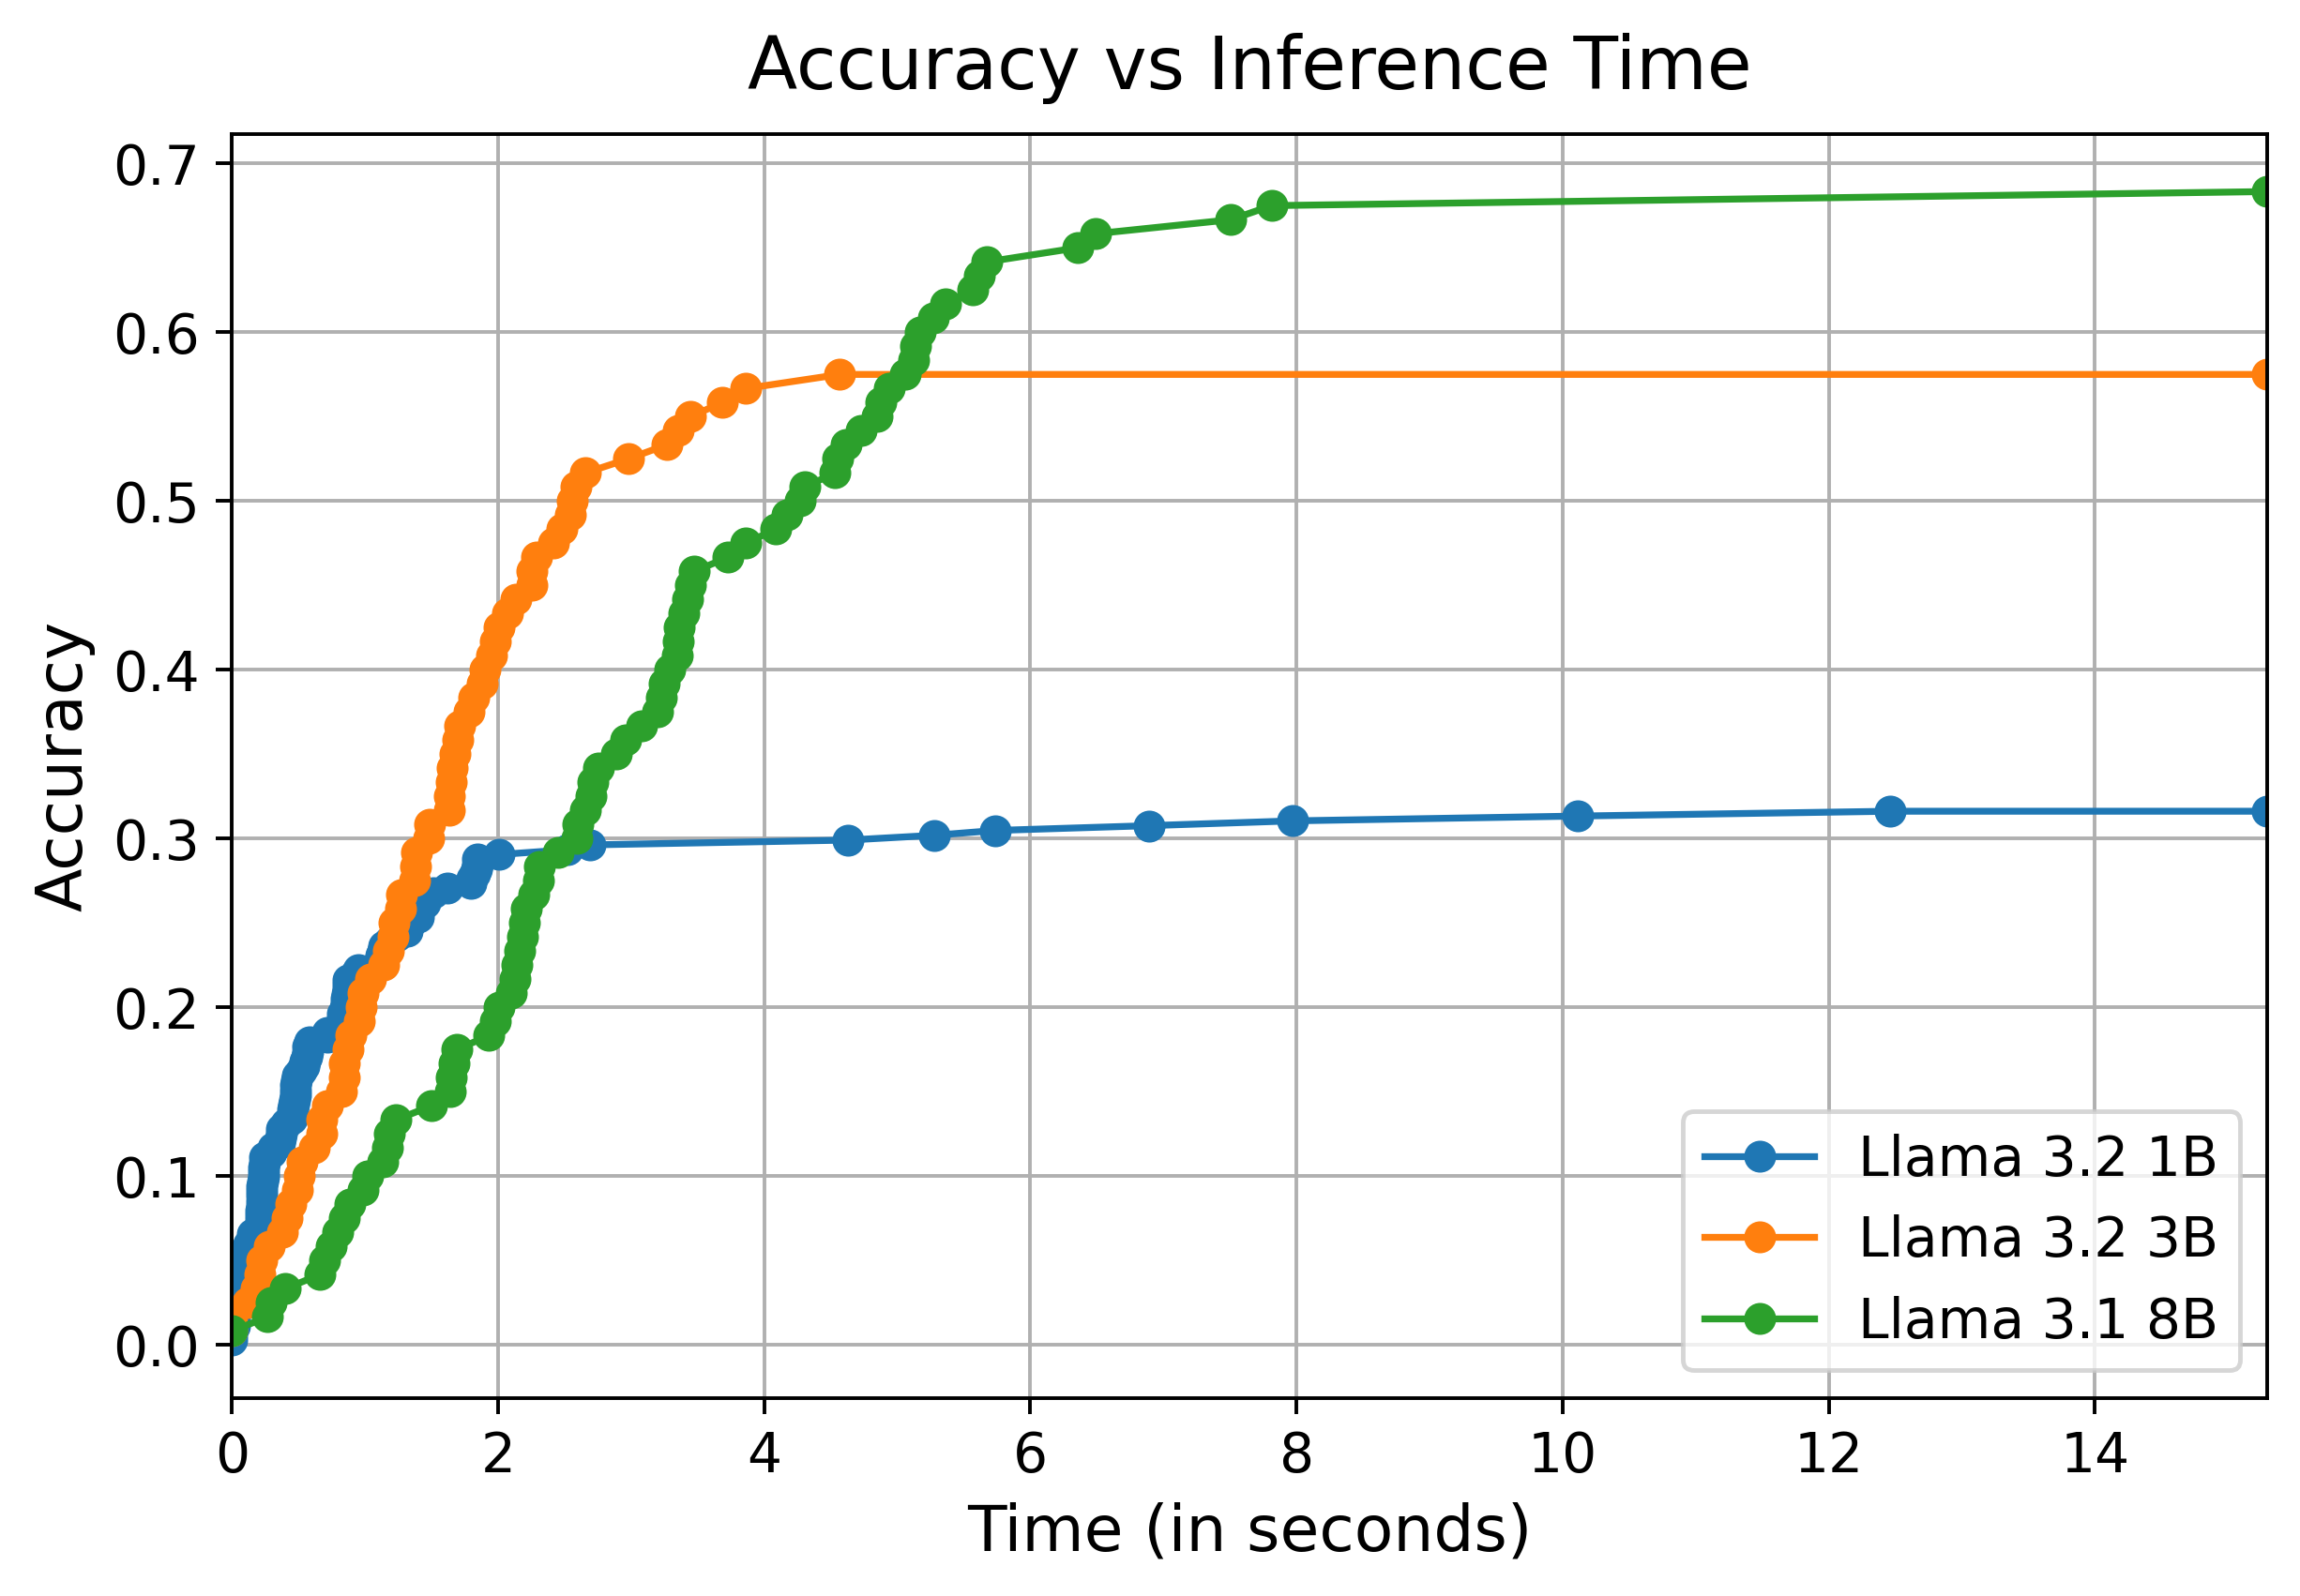

In [55]:
models_to_plot = [
 'Llama 3.2 1B',
 'Llama 3.2 3B',
 'Llama 3.1 8B',
 ]

list_of_datasets = []
list_of_labels = []
for key1 in models_to_plot:
    list_of_datasets.append(final_model_results[key1]["model_results"])
    list_of_labels.append(key1)
plot_multiple_cdfs_line_chart(list_of_datasets, list_of_labels, figsize=(8, 5), max_x = None)

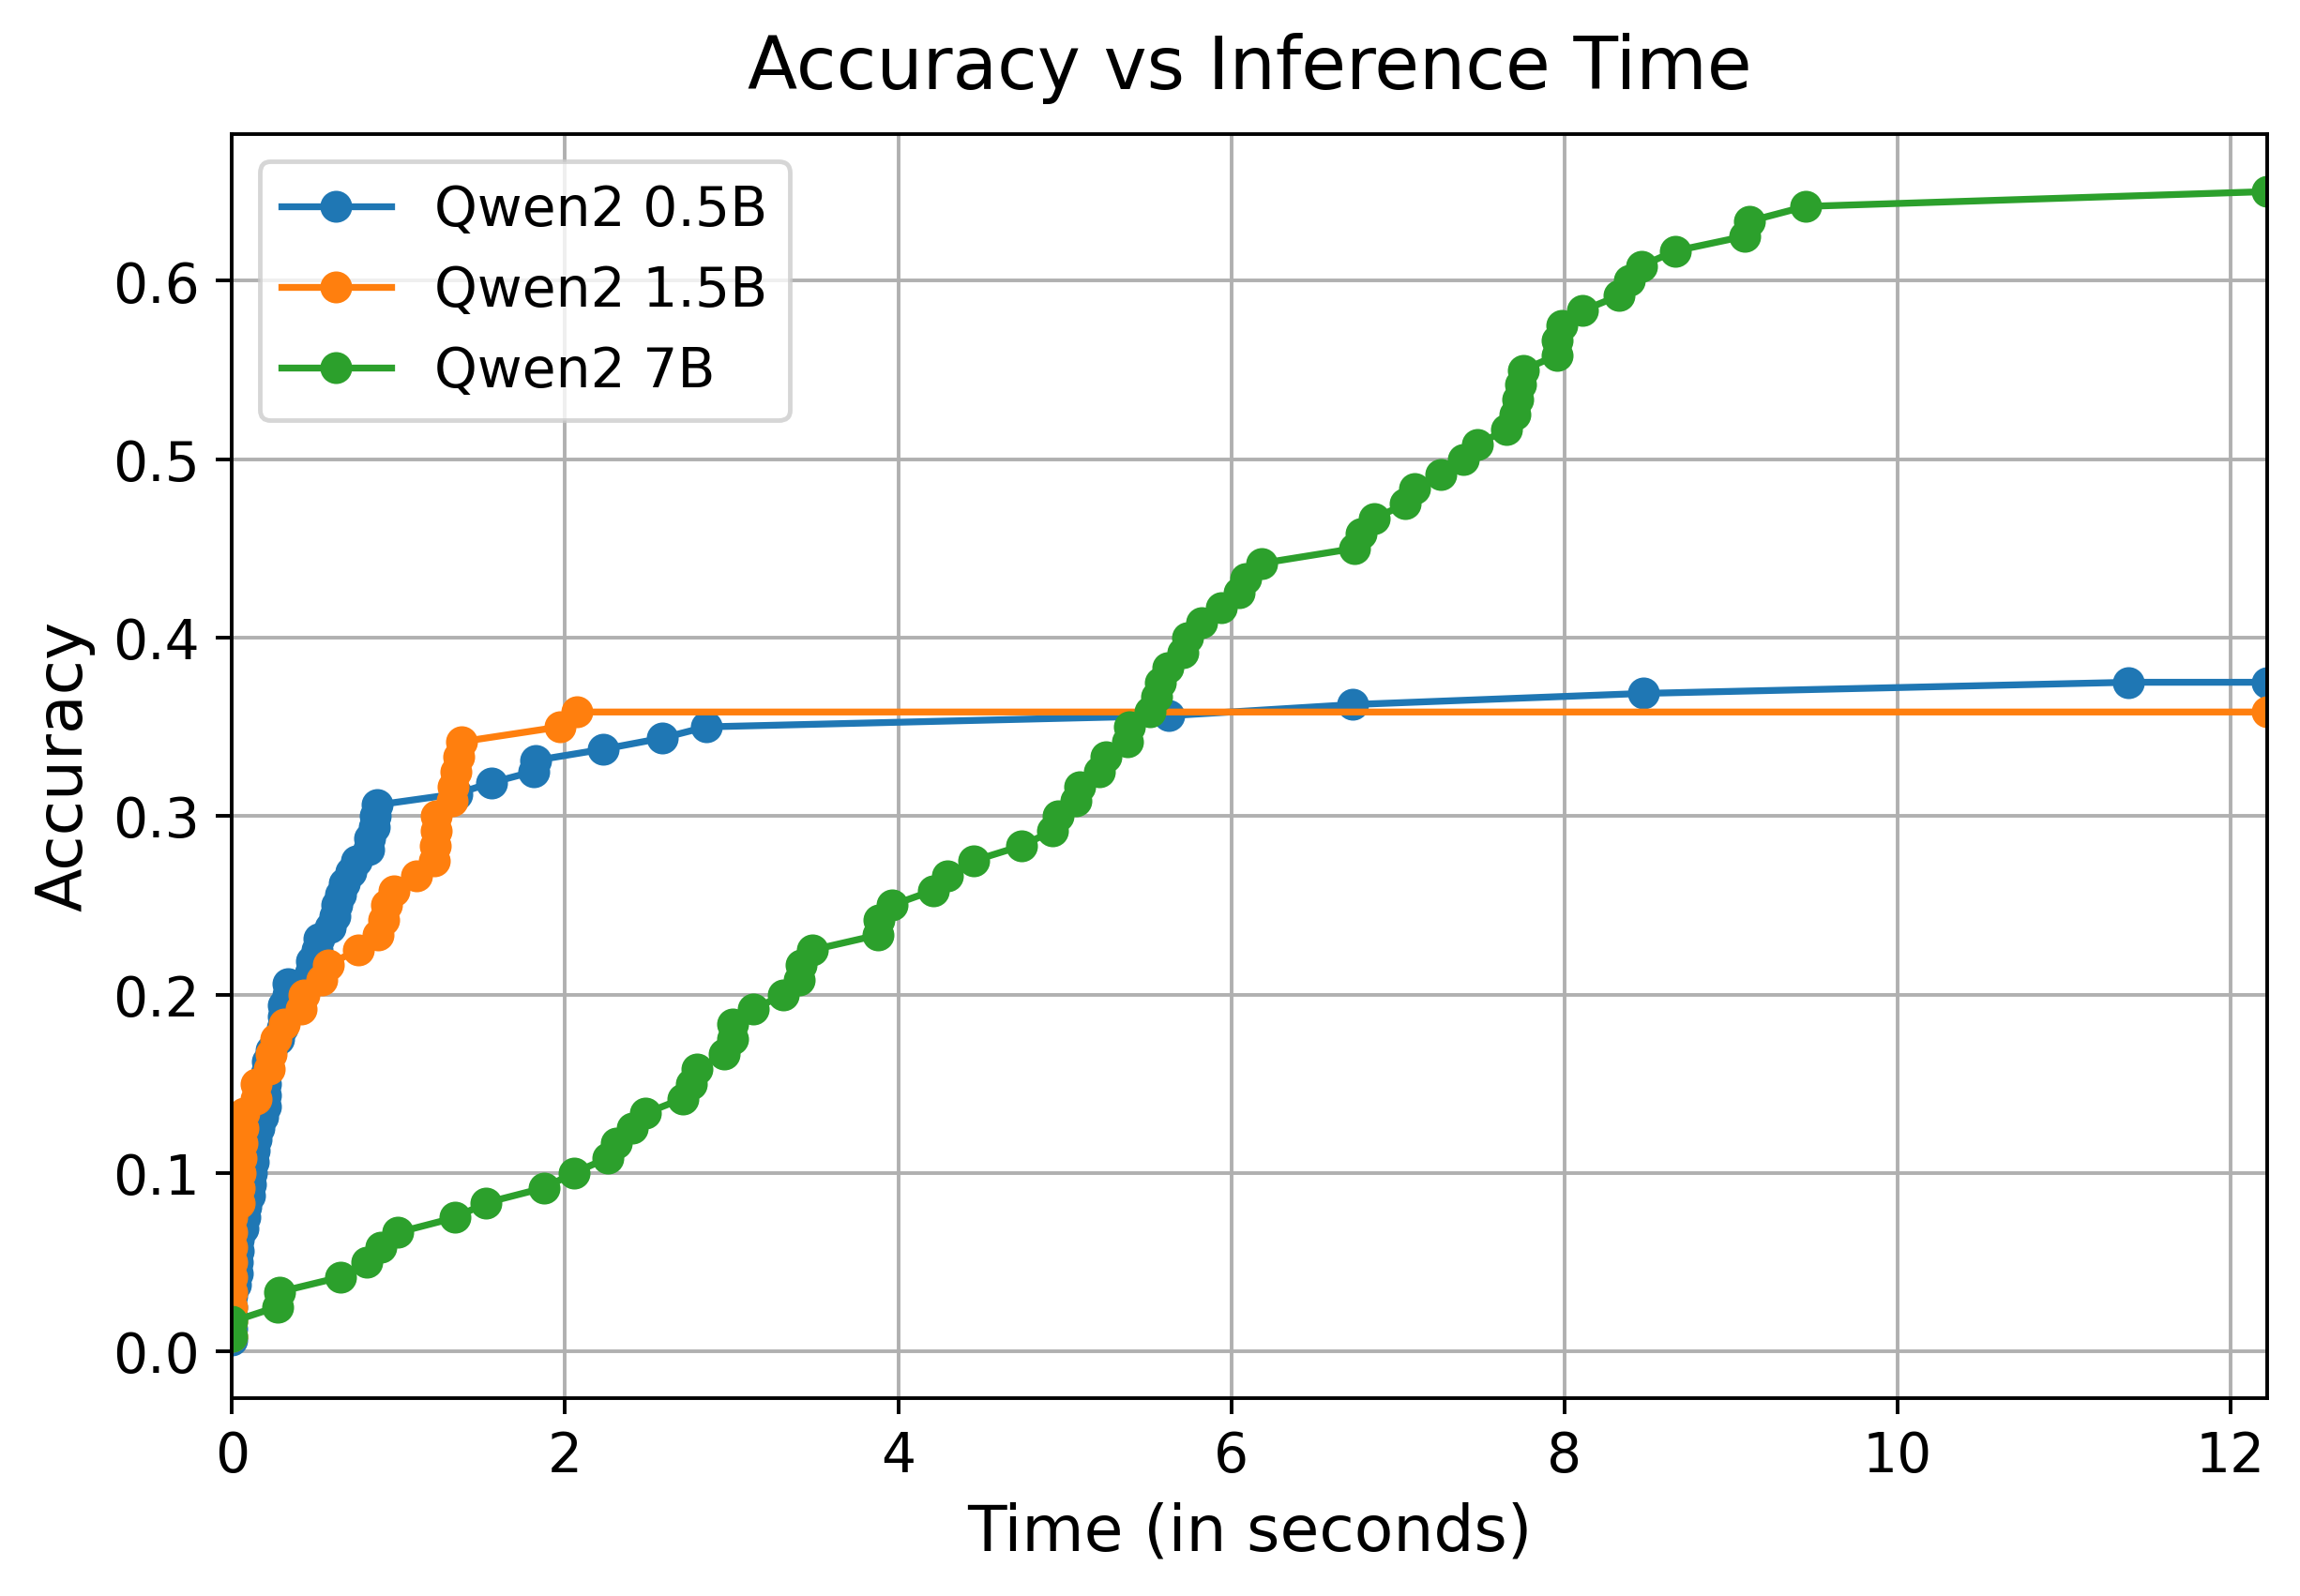

In [56]:
models_to_plot = [
 'Qwen2 0.5B',
 'Qwen2 1.5B',
 'Qwen2 7B']

list_of_datasets = []
list_of_labels = []
for key1 in models_to_plot:
    list_of_datasets.append(final_model_results[key1]["model_results"])
    list_of_labels.append(key1)
plot_multiple_cdfs_line_chart(list_of_datasets, list_of_labels, figsize=(8, 5), max_x = None)

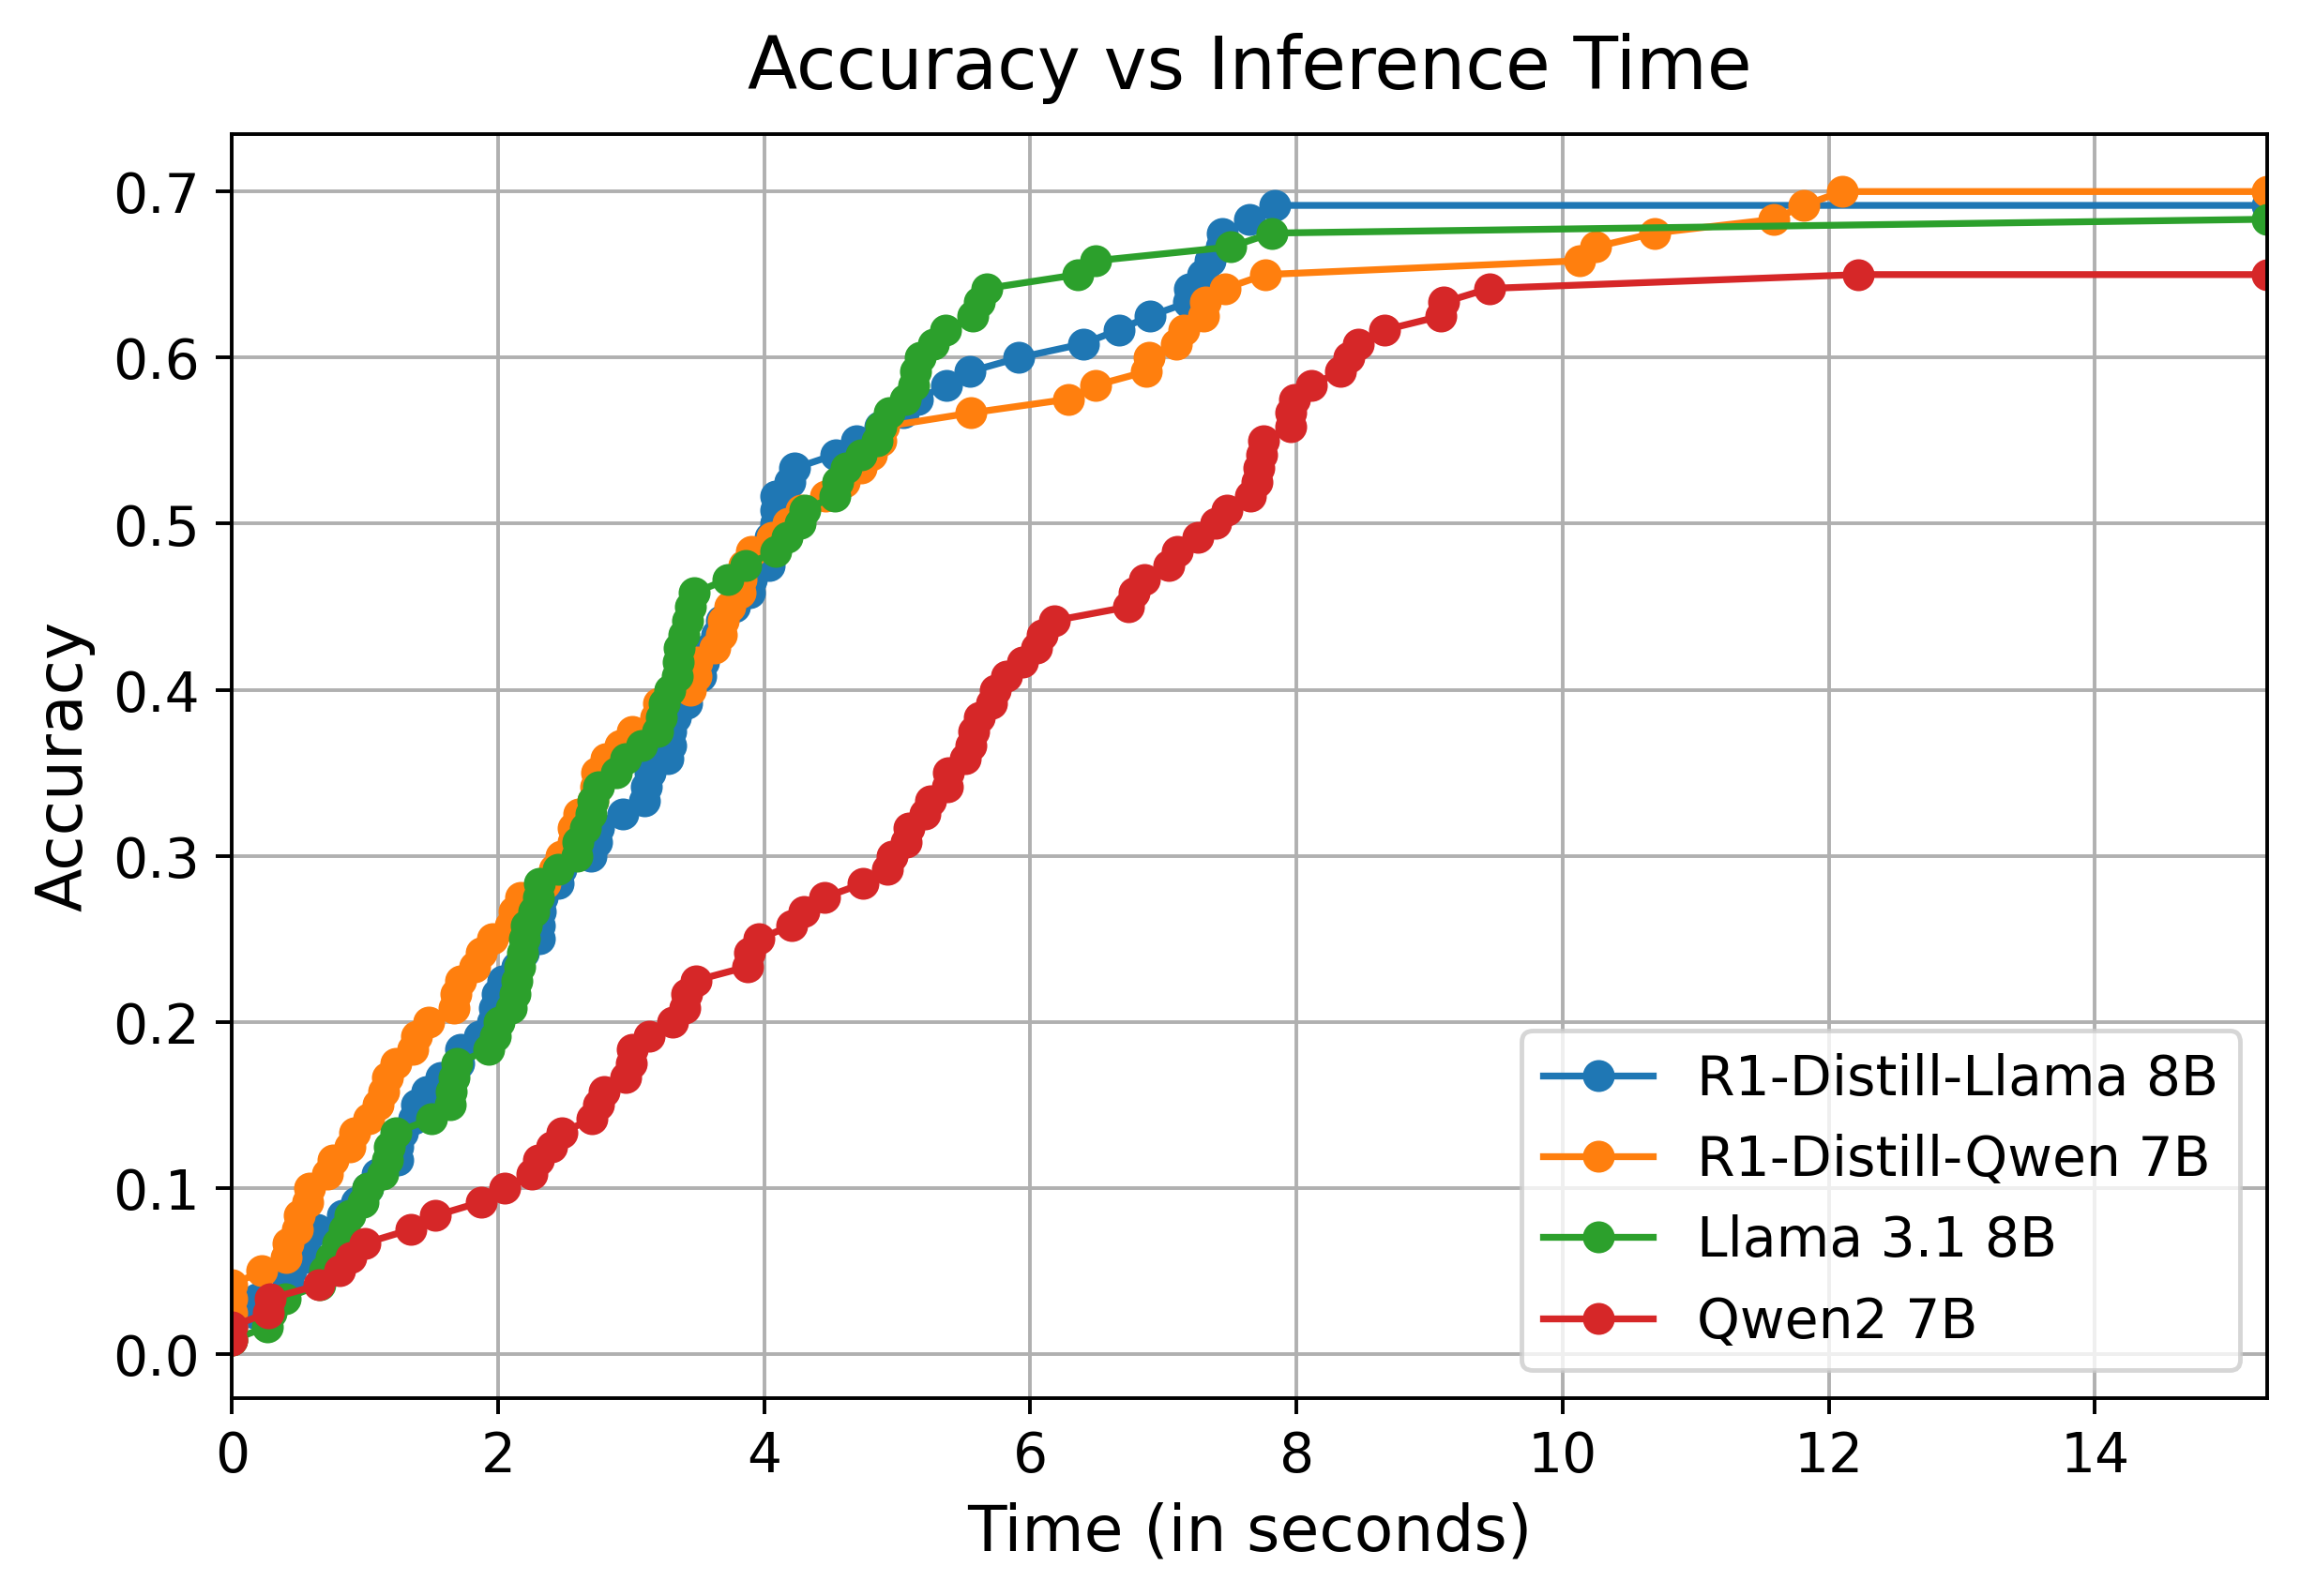

In [57]:
models_to_plot = ['R1-Distill-Llama 8B',
'R1-Distill-Qwen 7B',
'Llama 3.1 8B',
'Qwen2 7B'
]

list_of_datasets = []
list_of_labels = []
for key1 in models_to_plot:
    list_of_datasets.append(final_model_results[key1]["model_results"])
    list_of_labels.append(key1)
plot_multiple_cdfs_line_chart(list_of_datasets, list_of_labels, figsize=(8, 5), max_x = None)